In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy import integrate
from scipy.signal import argrelmin, argrelmax
import itertools
import os

matplotlib.rcParams.update({'font.size': 16})

In [27]:
def get_FE_profile(filename, ref_vol, fillna_bool=False):
    df = pd.read_csv(filename, sep='\s+')
    if fillna_bool:
        df = df.fillna(40000)
    else:
        df = df.dropna()
    #df = df.fillna(0)
    df = df.reset_index()

    if 'avg_press' not in df.columns:
        df['avg_press'] = df['Pressure']
    if 'volume' not in df.columns:
        df['volume'] = df['Volume']

    df['avg_press'] *= 101325
    closest_to_zero = (df['volume'] - ref_vol).apply(abs)
    rel_id = closest_to_zero.argmin()
    df['volume'] *= (1e-10)**3

    free_eng_list = [0]
    for i in range(1,len(df['avg_press'])):
        free_eng_list.append(-integrate.trapz(df['avg_press'].array[:i], x=df['volume'].array[:i]))
        
    free_eng = np.array(free_eng_list)
    free_eng *= 6.022e23 / 1000
    #free_eng -= min(free_eng)
    free_eng -= free_eng[rel_id]

    df['volume'] *= 1/((1e-10)**3)

    return df.copy(), free_eng

0 methane: 32    50562.396
Name: volume, dtype: float64, [-1762.60828196]
200 methane: 30    50562.396
Name: volume, dtype: float64, [-2624.24923427]
400 methane: 24    56525.551
Name: volume, dtype: float64, [-2939.90146701]
600 methane: 31    66814.425
Name: volume, dtype: float64, [-2952.57182485]
800 methane: 30    78281.69
Name: volume, dtype: float64, [-2806.0122331]
1000 methane: 35    89782.806
Name: volume, dtype: float64, [-2588.94549755]
1200 methane: 40    102358.6
Name: volume, dtype: float64, [-2344.62514415]
1400 methane: 44    114635.33
Name: volume, dtype: float64, [-2087.78078611]


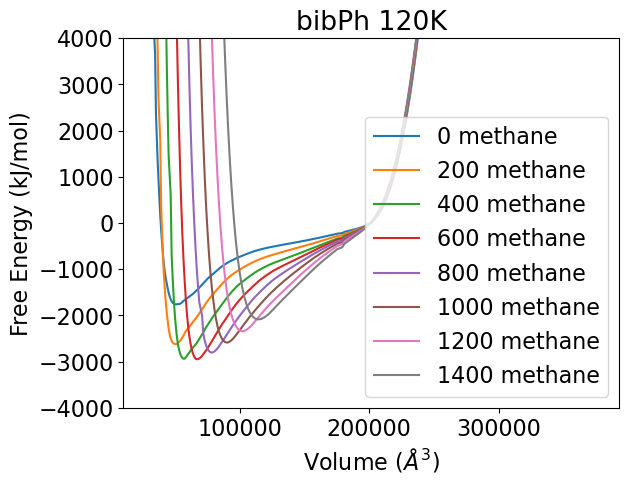

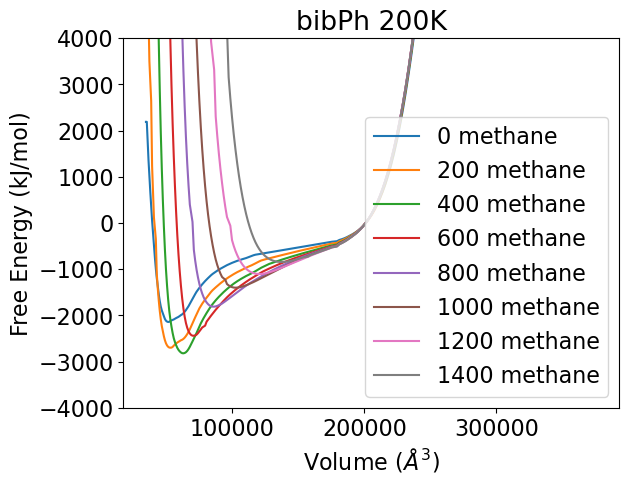

dict_keys([0, 200, 400, 600, 800, 1000, 1200, 1400])

0 methane: 29    50562.396
Name: volume, dtype: float64, [-2127.17753312]
200 methane: 23    53063.825
Name: volume, dtype: float64, [-2146.67612976]
400 methane: 30    65831.339
Name: volume, dtype: float64, [-1443.06578961]
600 methane: 43    87398.144
Name: volume, dtype: float64, [-787.26200822]
800 methane: 62    121861.55
Name: volume, dtype: float64, [-386.9985814]
1000 methane: 78    159026.32
Name: volume, dtype: float64, [-250.9382173]
1200 methane: 78    181110.25
Name: volume, dtype: float64, [-161.37325005]
1400 methane: 75    186933.52
Name: volume, dtype: float64, [-83.11416699]


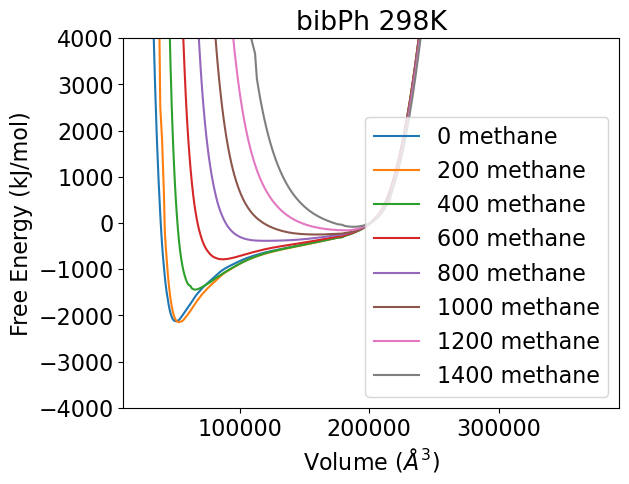

dict_keys([0, 200, 400, 600, 800, 1000, 1200, 1400])

0 methane: 6    53063.825
Name: volume, dtype: float64, [-1578.27571035]
200 methane: 13    60134.649
19    66814.425
Name: volume, dtype: float64, [-1174.13003527 -1149.0407654 ]
400 methane: 29    76106.204
Name: volume, dtype: float64, [-385.14082665]
600 methane: 90    179196.39
Name: volume, dtype: float64, [-100.37846368]
800 methane: 93    190884.23
Name: volume, dtype: float64, [-47.44476797]
1000 methane: 87    198951.86
Name: volume, dtype: float64, [-12.23805245]
1200 methane: 71    201003.68
Name: volume, dtype: float64, [0.]
1400 methane: 77    203069.55
Name: volume, dtype: float64, [-8.68156852]


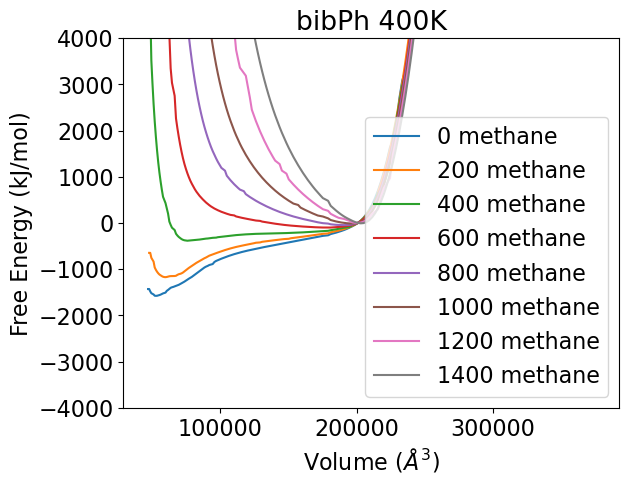

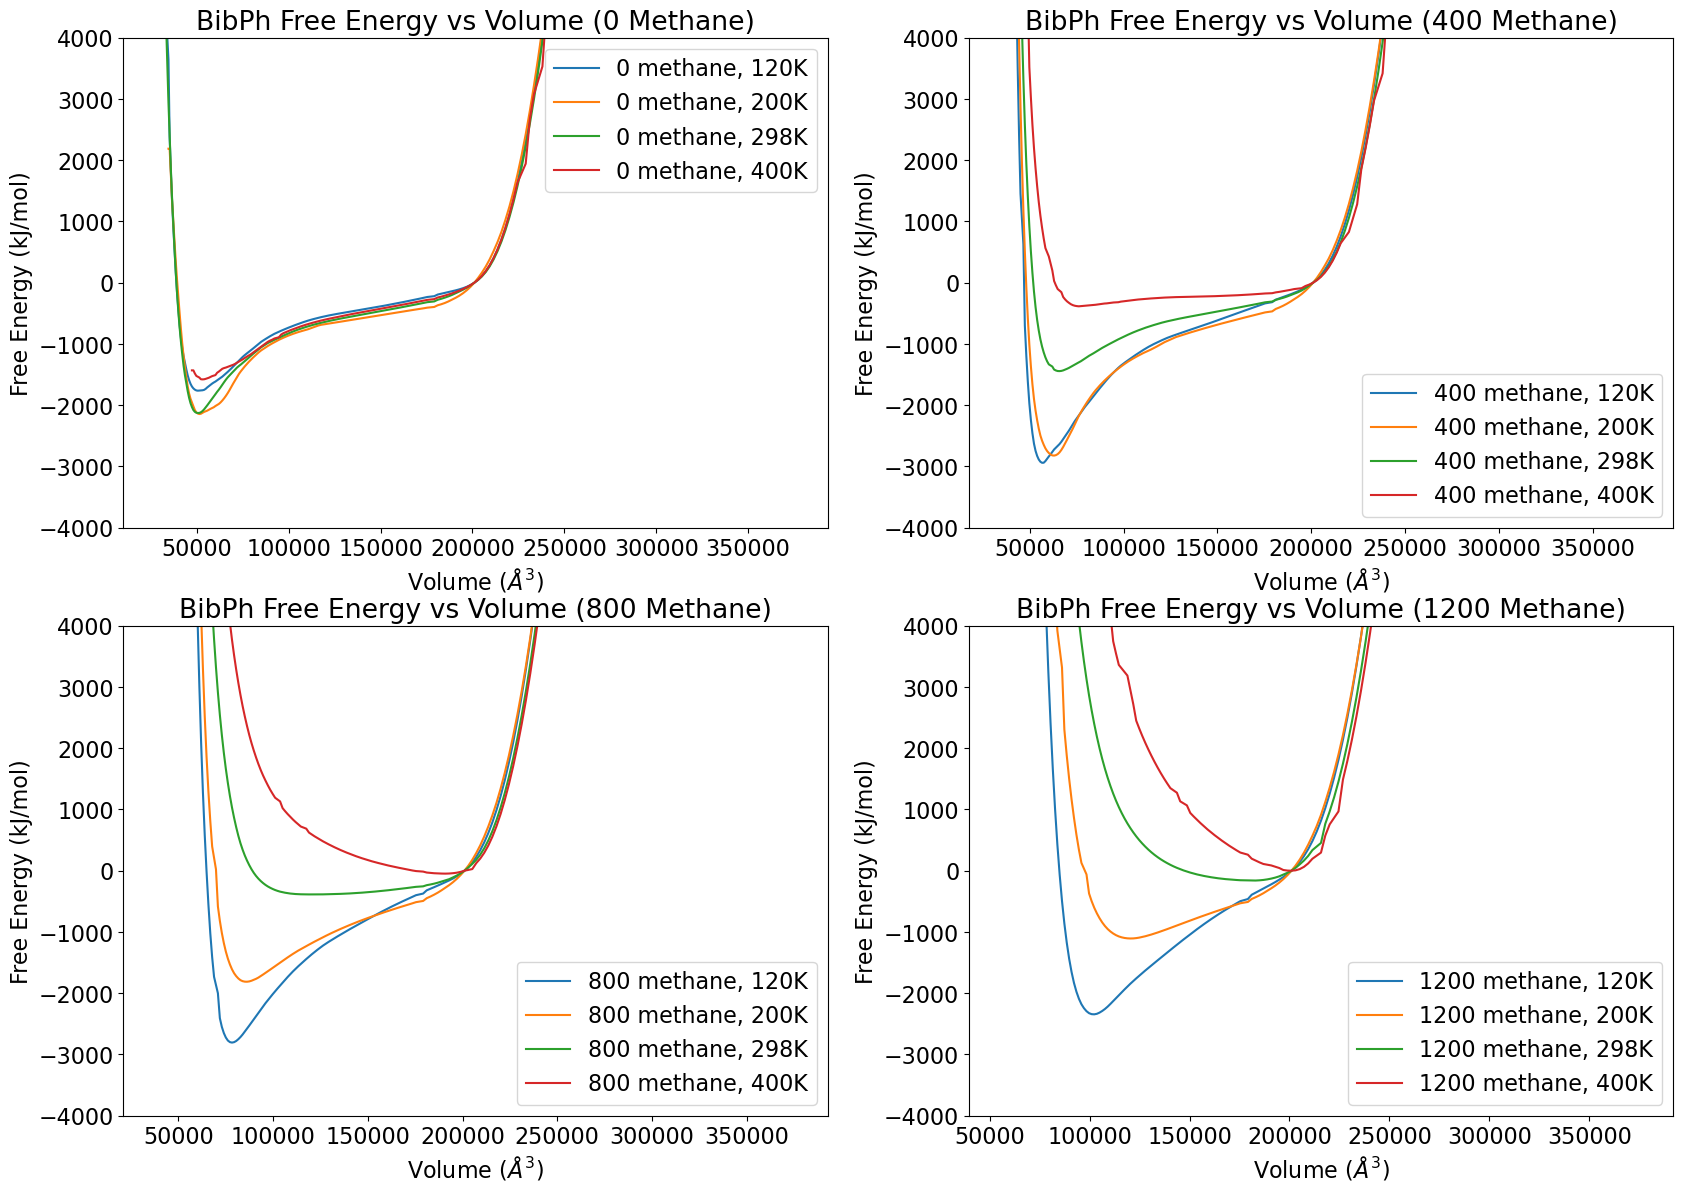

In [29]:
# Read in free energies and volumes from each file in FreeEnergy_Sept_data using get_FE_profile

bibPh_120K_data_dict = {}
bibPh_200K_data_dict = {}
bibPh_298K_data_dict = {}
bibPh_400K_data_dict = {}

# 1. Read in the data
for file in os.listdir('FreeEnergy_Sept_data'):
    if file.endswith('.txt'):
        #print(file)
        df, free_eng = get_FE_profile('FreeEnergy_Sept_data/' + file, 200000)
        if 'bibPh' in file and '120K' in file:
            num_methane = int(file.split('_')[3].split('m')[0])
            bibPh_120K_data_dict[num_methane] = (df, free_eng)
        elif 'bibPh' in file and '200K' in file:
            num_methane = int(file.split('_')[3].split('m')[0])
            bibPh_200K_data_dict[num_methane] = (df, free_eng)
        elif 'bibPh' in file and '298K' in file:
            num_methane = int(file.split('_')[3].split('m')[0])
            bibPh_298K_data_dict[num_methane] = (df, free_eng)
        elif 'bibPh' in file and '400K' in file:
            num_methane = int(file.split('_')[3].split('m')[0])
            bibPh_400K_data_dict[num_methane] = (df, free_eng)
            #print(file)

# Sort the data by number of methane molecules
bibPh_120K_data_dict = dict(sorted(bibPh_120K_data_dict.items()))
bibPh_200K_data_dict = dict(sorted(bibPh_200K_data_dict.items()))
bibPh_298K_data_dict = dict(sorted(bibPh_298K_data_dict.items()))
bibPh_400K_data_dict = dict(sorted(bibPh_400K_data_dict.items()))

# 2. Plot the data
fig, ax = plt.subplots()
for num_methane, (df, free_eng) in bibPh_120K_data_dict.items():
    ax.plot(df['volume'], free_eng, label=f'{num_methane} methane')
    masked_FE = free_eng[free_eng < 1000]
    minima_indices = argrelmin(masked_FE)
    # print the volume and free energy of the minima
    print(f'{num_methane} methane: {df["volume"][free_eng < 1000].iloc[minima_indices]}, {masked_FE[minima_indices]}')

ax.legend()
ax.set_xlabel('Volume ($\AA^3$)')
ax.set_ylabel('Free Energy (kJ/mol)')
ax.set_ylim(-4000, 4000)
plt.title('bibPh 120K')
plt.savefig('bibPh_120K.png', dpi=400)
plt.show()

ax.set_prop_cycle(None)

fig, ax = plt.subplots()
for num_methane, (df, free_eng) in bibPh_200K_data_dict.items():
    ax.plot(df['volume'], free_eng, label=f'{num_methane} methane')#, linestyle='--')

ax.legend()
ax.set_xlabel('Volume ($\AA^3$)')
ax.set_ylabel('Free Energy (kJ/mol)')
ax.set_ylim(-4000, 4000)
plt.title('bibPh 200K')
plt.savefig('bibPh_200K.png', dpi=400)
plt.show()

print(bibPh_298K_data_dict.keys())
print()
fig, ax = plt.subplots()
for num_methane, (df, free_eng) in bibPh_298K_data_dict.items():
    ax.plot(df['volume'], free_eng, label=f'{num_methane} methane')#, linestyle=':')
    masked_FE = free_eng[free_eng < 1000]
    minima_indices = argrelmin(masked_FE)
    # print the volume and free energy of the minima
    print(f'{num_methane} methane: {df["volume"][free_eng < 1000].iloc[minima_indices]}, {masked_FE[minima_indices]}')

ax.legend()
ax.set_xlabel('Volume ($\AA^3$)')
ax.set_ylabel('Free Energy (kJ/mol)')
ax.set_ylim(-4000, 4000)
plt.title('bibPh 298K')
plt.savefig('bibPh_298K.png', dpi=400)
plt.show()


print(bibPh_400K_data_dict.keys())
print()
fig, ax = plt.subplots()
for num_methane, (df, free_eng) in bibPh_400K_data_dict.items():
    ax.plot(df['volume'], free_eng, label=f'{num_methane} methane')#, linestyle=':')
    masked_FE = free_eng[free_eng < 1000]
    minima_indices = argrelmin(masked_FE)
    # print the volume and free energy of the minima
    print(f'{num_methane} methane: {df["volume"][free_eng < 1000].iloc[minima_indices]}, {masked_FE[minima_indices]}')

ax.legend()
ax.set_xlabel('Volume ($\AA^3$)')
ax.set_ylabel('Free Energy (kJ/mol)')
ax.set_ylim(-4000, 4000)
plt.title('bibPh 400K')
plt.savefig('bibPh_400K.png', dpi=400)
plt.show()

# Plot by loading with temperature in legend, volume on x-axis, and free energy on y-axis
fig, ax = plt.subplots(2, 2, figsize=(20, 14))
for T in [120, 200, 298, 400]:
    for num_methane, (df, free_eng) in eval(f'bibPh_{T}K_data_dict').items():
        if num_methane == 0:
            ax[0,0].plot(df['volume'], free_eng, label=f'{num_methane} methane, {T}K')
        if num_methane == 400:
            ax[0,1].plot(df['volume'], free_eng, label=f'{num_methane} methane, {T}K')
        if num_methane == 800:
            ax[1,0].plot(df['volume'], free_eng, label=f'{num_methane} methane, {T}K')
        if num_methane == 1200:
            ax[1,1].plot(df['volume'], free_eng, label=f'{num_methane} methane, {T}K')

ax[0,0].legend(); ax[0,1].legend(); ax[1,0].legend(); ax[1,1].legend()
ax[0,0].set_xlabel('Volume ($\AA^3$)'); ax[0,1].set_xlabel('Volume ($\AA^3$)'); ax[1,0].set_xlabel('Volume ($\AA^3$)'); ax[1,1].set_xlabel('Volume ($\AA^3$)')
ax[0,0].set_ylabel('Free Energy (kJ/mol)'); ax[0,1].set_ylabel('Free Energy (kJ/mol)'); ax[1,0].set_ylabel('Free Energy (kJ/mol)'); ax[1,1].set_ylabel('Free Energy (kJ/mol)')
ax[0,0].set_ylim(-4000, 4000); ax[0,1].set_ylim(-4000, 4000); ax[1,0].set_ylim(-4000, 4000); ax[1,1].set_ylim(-4000, 4000)
ax[0,0].set_title('BibPh Free Energy vs Volume (0 Methane)')
ax[0,1].set_title('BibPh Free Energy vs Volume (400 Methane)')
ax[1,0].set_title('BibPh Free Energy vs Volume (800 Methane)')
ax[1,1].set_title('BibPh Free Energy vs Volume (1200 Methane)')

plt.savefig('BibPh_Free_Energy_vs_Volume_by_Loading_and_Temperature.png', dpi=400)
plt.show()

pressures_bipy_400K_0mol.txt
pressures_bipy_400K_1000mol.txt
pressures_bipy_400K_1200mol.txt
pressures_bipy_400K_200mol.txt
pressures_bipy_400K_400mol.txt
pressures_bipy_400K_600mol.txt
pressures_bipy_400K_800mol.txt
0 methane: 20     47872.63
70    100611.31
Name: volume, dtype: float64, [1800.04689362    0.        ]
Energy Well Difference: 1800.046893623803
maxima_indices: (array([9], dtype=int64),)
g* left to right: -103.52964865990134
g* right to left: -1903.5765422837044
200 methane: 19     47085.915
70    100611.310
Name: volume, dtype: float64, [982.6942644   0.       ]
Energy Well Difference: 982.6942644038927
maxima_indices: (array([15], dtype=int64),)
g* left to right: -397.6780524464257
g* right to left: -1380.3723168503184
400 methane: 18     51107.114
64    100611.310
Name: volume, dtype: float64, [733.38497377   0.        ]
Energy Well Difference: 733.3849737692908
maxima_indices: (array([15], dtype=int64),)
g* left to right: -227.92225615220377
g* right to left: -961.307

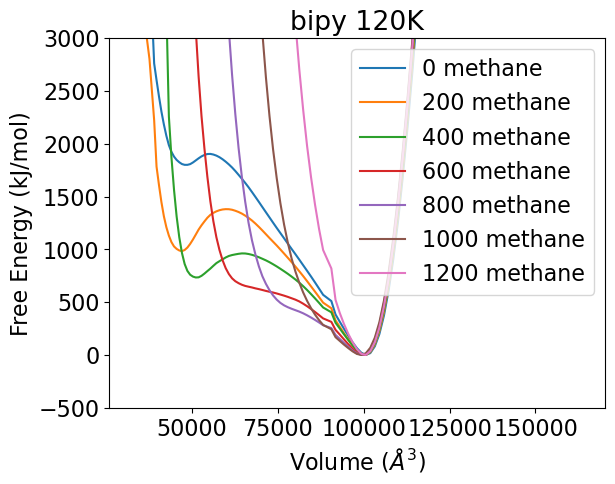

0 methane: 15     46307.867
68    101914.830
Name: volume, dtype: float64, [1654.72802208   -1.68073693]
Energy Well Difference: 1656.4087590148679
maxima_indices: (array([11], dtype=int64),)
g* left to right: -130.51852035751062
g* right to left: -1786.9272793723785
200 methane: 14     46307.867
66    100611.310
Name: volume, dtype: float64, [1048.95233009    0.        ]
Energy Well Difference: 1048.9523300913243
maxima_indices: (array([17], dtype=int64),)
g* left to right: -273.2419650912843
g* right to left: -1322.1942951826086
400 methane: 63    100611.31
Name: volume, dtype: float64, [0.]
600 methane: 60    100611.31
Name: volume, dtype: float64, [0.]
800 methane: 48    100611.31
Name: volume, dtype: float64, [0.]
1000 methane: 47    101914.83
Name: volume, dtype: float64, [-9.79609078]
1200 methane: 37    103229.56
Name: volume, dtype: float64, [-89.967944]


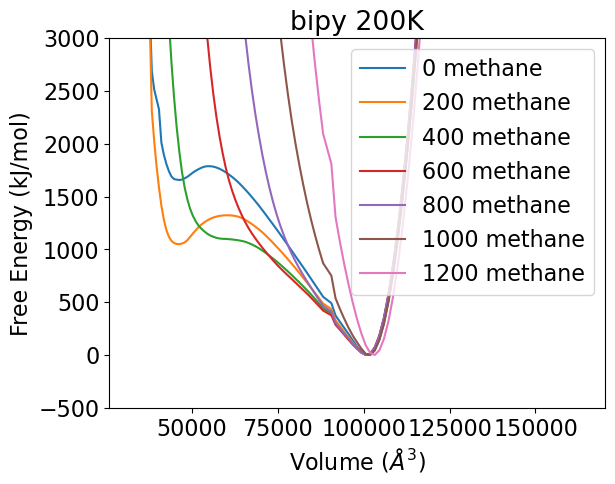

dict_keys([0, 200, 400, 600, 800, 1000, 1200])

0 methane: 23     45538.437
76    100611.310
Name: volume, dtype: float64, [1657.40216922    0.        ]
Energy Well Difference: 1657.4021692167644
maxima_indices: (array([11], dtype=int64),)
g* left to right: -119.13758755189338
g* right to left: -1776.5397567686578
200 methane: 14     47872.63
64    100611.31
Name: volume, dtype: float64, [1499.29296914    0.        ]
Energy Well Difference: 1499.2929691397003
maxima_indices: (array([7], dtype=int64),)
g* left to right: -50.99228494829549
g* right to left: -1550.2852540879958
400 methane: 61    100611.31
Name: volume, dtype: float64, [0.]
600 methane: 53    101914.83
Name: volume, dtype: float64, [-3.5217292]
800 methane: 44    101914.83
Name: volume, dtype: float64, [-20.87030127]
1000 methane: 38    103229.56
Name: volume, dtype: float64, [-80.83404233]
1200 methane: 33    104555.54
Name: volume, dtype: float64, [-328.40536212]


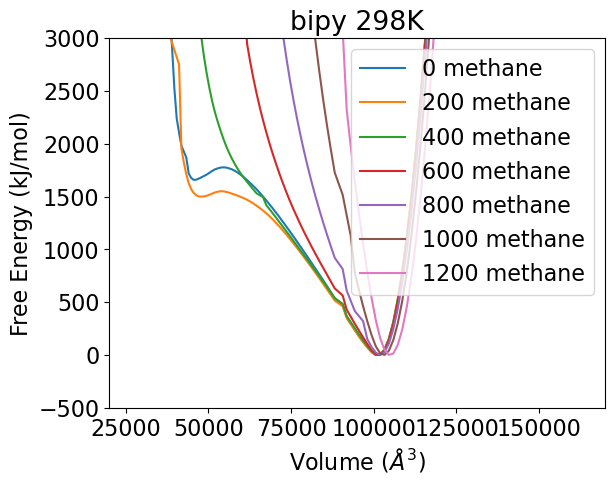

dict_keys([0, 200, 400, 600, 800, 1000, 1200])

0 methane: 3      45538.437
52    100611.310
Name: volume, dtype: float64, [1588.76598678    0.        ]
Energy Well Difference: 1588.7659867786765
maxima_indices: (array([9], dtype=int64),)
g* left to right: -189.02951722795865
g* right to left: -1777.7955040066352
200 methane: 55    100611.31
Name: volume, dtype: float64, [0.]
400 methane: 57    101914.83
Name: volume, dtype: float64, [-4.09464207]
600 methane: 51    101914.83
Name: volume, dtype: float64, [-21.73525503]
800 methane: 39    103229.56
Name: volume, dtype: float64, [-55.0463441]
1000 methane: 31    104555.54
Name: volume, dtype: float64, [-189.80677555]
1200 methane: 26    105892.83
Name: volume, dtype: float64, [-616.89479541]


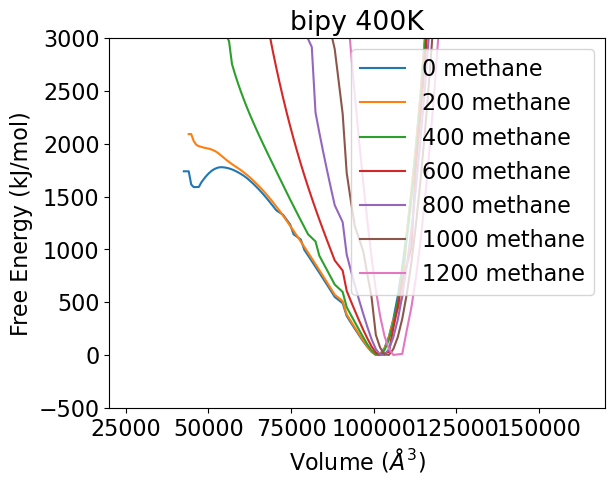

{0: 1800.046893623803, 200: 982.6942644038927, 400: 733.3849737692908}
{0: 1656.4087590148679, 200: 1048.9523300913243}
{0: 1657.4021692167644, 200: 1499.2929691397003}


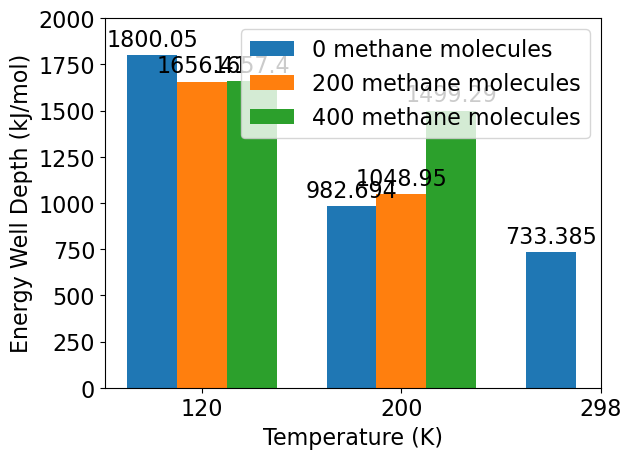

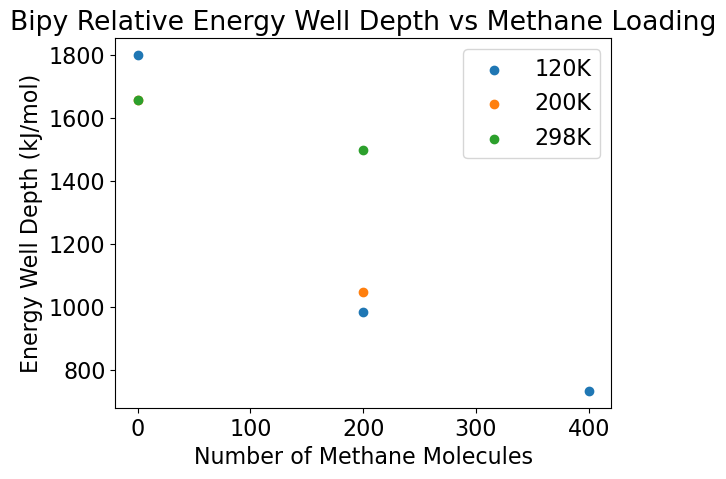

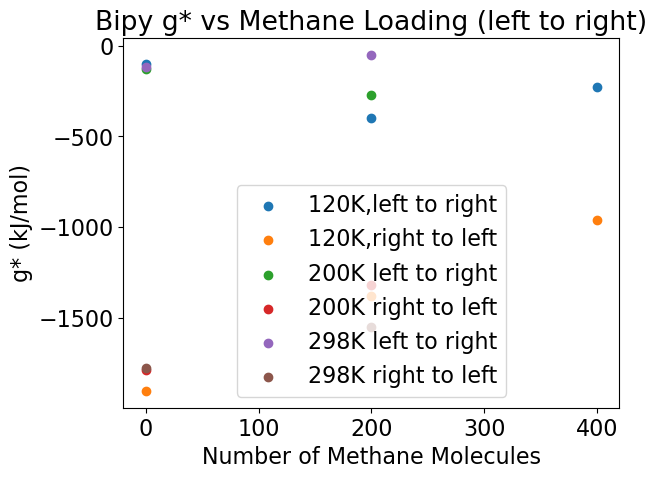

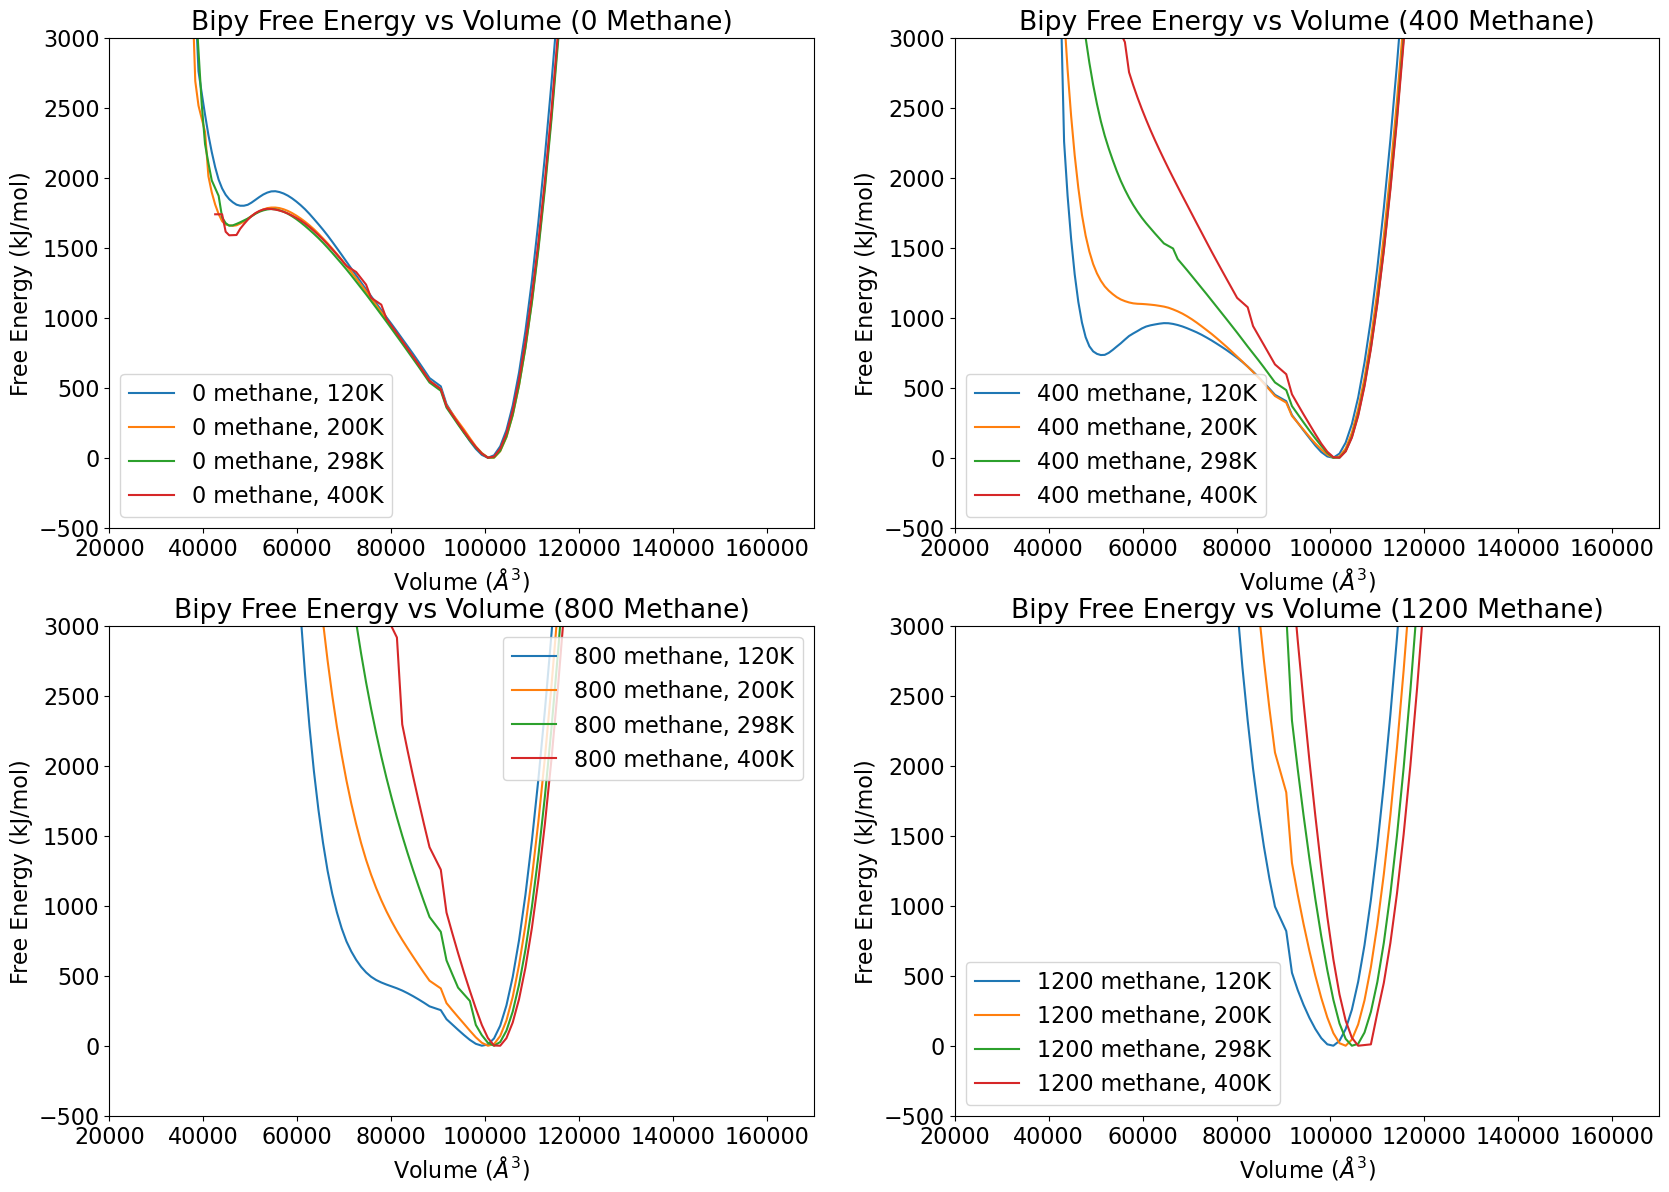

In [31]:
# Read in free energies and volumes from each file in FreeEnergy_Sept_data using get_FE_profile

bipy_120K_data_dict = {}
bipy_200K_data_dict = {}
bipy_298K_data_dict = {}
bipy_400K_data_dict = {}
bipy_120K_depth_dict = {}
bipy_200K_depth_dict = {}
bipy_298K_depth_dict = {}
bipy_400K_depth_dict = {}
del_g_star_ltor_dict = {120:[], 200:[], 298:[], 400:[]}
del_g_star_ltor_methane = {120:[], 200:[], 298:[], 400:[]}
del_g_star_rtol_dict = {120:[], 200:[], 298:[], 400:[]}
del_g_star_rtol_methane = {120:[], 200:[], 298:[], 400:[]}

# 1. Read in the data
for file in os.listdir('FreeEnergy_Sept_data'):
    if file.endswith('.txt'):
        #print(file)
        df, free_eng = get_FE_profile('FreeEnergy_Sept_data/' + file, 100000)
        if 'bipy' in file and '120K' in file:
            num_methane = int(file.split('_')[3].split('m')[0])
            bipy_120K_data_dict[num_methane] = (df, free_eng)
        elif 'bipy' in file and '200K' in file:
            num_methane = int(file.split('_')[3].split('m')[0])
            bipy_200K_data_dict[num_methane] = (df, free_eng)
        elif 'bipy' in file and '298K' in file:
            num_methane = int(file.split('_')[3].split('m')[0])
            bipy_298K_data_dict[num_methane] = (df, free_eng)
        elif 'bipy' in file and '400K' in file:
            num_methane = int(file.split('_')[3].split('m')[0])
            bipy_400K_data_dict[num_methane] = (df, free_eng)
            print(file)

# Sort the data by number of methane molecules
bipy_120K_data_dict = dict(sorted(bipy_120K_data_dict.items()))
bipy_200K_data_dict = dict(sorted(bipy_200K_data_dict.items()))
bipy_298K_data_dict = dict(sorted(bipy_298K_data_dict.items()))
bipy_400K_data_dict = dict(sorted(bipy_400K_data_dict.items()))

# 2. Plot the data
fig, ax = plt.subplots()
for num_methane, (df, free_eng) in bipy_120K_data_dict.items():
    ax.plot(df['volume'], free_eng - free_eng.min(), label=f'{num_methane} methane')
    masked_FE = free_eng[free_eng < 2500]
    minima_indices = argrelmin(masked_FE)
    # print the volume and free energy of the minima
    print(f'{num_methane} methane: {df["volume"][free_eng < 2500].iloc[minima_indices]}, {masked_FE[minima_indices]}')
    if len(minima_indices[0]) > 1:
        print(f'Energy Well Difference: {masked_FE[minima_indices[0][0]] - masked_FE[minima_indices[0][1]]}')
        bipy_120K_depth_dict[num_methane] = masked_FE[minima_indices[0][0]] - masked_FE[minima_indices[0][1]]
        # find maximum between the two minima
        maxima_indices = argrelmax(masked_FE[minima_indices[0][0]:minima_indices[0][1]])
        print(f'maxima_indices: {maxima_indices}')
        g_star_ltor = masked_FE[minima_indices[0][0]] - masked_FE[minima_indices[0][0]:minima_indices[0][1]][maxima_indices[0][0]]
        g_star_rtol = masked_FE[minima_indices[0][1]] - masked_FE[minima_indices[0][0]:minima_indices[0][1]][maxima_indices[0][0]]
        print(f'g* left to right: {g_star_ltor}')
        print(f'g* right to left: {g_star_rtol}')
        # save the g* values
        del_g_star_ltor_dict[120].append(g_star_ltor)
        del_g_star_rtol_dict[120].append(g_star_rtol)
        del_g_star_ltor_methane[120].append(num_methane)
        del_g_star_rtol_methane[120].append(num_methane)
    

ax.legend()
ax.set_xlabel('Volume ($\AA^3$)')
ax.set_ylabel('Free Energy (kJ/mol)')
ax.set_ylim(-500, 3000)
plt.title('bipy 120K')
plt.savefig('bipy_120K.png', dpi=400)
plt.show()

fig, ax = plt.subplots()
for num_methane, (df, free_eng) in bipy_200K_data_dict.items():
    ax.plot(df['volume'], free_eng - free_eng.min(), label=f'{num_methane} methane')#, linestyle='--')
    masked_FE = free_eng[free_eng < 2500]
    minima_indices = argrelmin(masked_FE)
    # print the volume and free energy of the minima
    print(f'{num_methane} methane: {df["volume"][free_eng < 2500].iloc[minima_indices]}, {masked_FE[minima_indices]}')
    if len(minima_indices[0]) > 1:
        print(f'Energy Well Difference: {masked_FE[minima_indices[0][0]] - masked_FE[minima_indices[0][1]]}')
        bipy_200K_depth_dict[num_methane] = masked_FE[minima_indices[0][0]] - masked_FE[minima_indices[0][1]]
        # find maximum between the two minima
        maxima_indices = argrelmax(masked_FE[minima_indices[0][0]:minima_indices[0][1]])
        print(f'maxima_indices: {maxima_indices}')
        g_star_ltor = masked_FE[minima_indices[0][0]] - masked_FE[minima_indices[0][0]:minima_indices[0][1]][maxima_indices[0][0]]
        g_star_rtol = masked_FE[minima_indices[0][1]] - masked_FE[minima_indices[0][0]:minima_indices[0][1]][maxima_indices[0][0]]
        print(f'g* left to right: {g_star_ltor}')
        print(f'g* right to left: {g_star_rtol}')
        # save the g* values
        del_g_star_ltor_dict[200].append(g_star_ltor)
        del_g_star_rtol_dict[200].append(g_star_rtol)
        del_g_star_ltor_methane[200].append(num_methane)
        del_g_star_rtol_methane[200].append(num_methane)

ax.legend()
ax.set_xlabel('Volume ($\AA^3$)')
ax.set_ylabel('Free Energy (kJ/mol)')
ax.set_ylim(-500, 3000)
plt.title('bipy 200K')
plt.savefig('bipy_200K.png', dpi=400)
plt.show()

print(bipy_298K_data_dict.keys())
print()
fig, ax = plt.subplots()
for num_methane, (df, free_eng) in bipy_298K_data_dict.items():
    ax.plot(df['volume'], free_eng - free_eng.min(), label=f'{num_methane} methane')#, linestyle=':')
    masked_FE = free_eng[free_eng < 2500]
    minima_indices = argrelmin(masked_FE)
    # print the volume and free energy of the minima
    print(f'{num_methane} methane: {df["volume"][free_eng < 2500].iloc[minima_indices]}, {masked_FE[minima_indices]}')
    if len(minima_indices[0]) > 1:
        print(f'Energy Well Difference: {masked_FE[minima_indices[0][0]] - masked_FE[minima_indices[0][1]]}')
        bipy_298K_depth_dict[num_methane] = masked_FE[minima_indices[0][0]] - masked_FE[minima_indices[0][1]]
        # find maximum between the two minima
        maxima_indices = argrelmax(masked_FE[minima_indices[0][0]:minima_indices[0][1]])
        print(f'maxima_indices: {maxima_indices}')
        g_star_ltor = masked_FE[minima_indices[0][0]] - masked_FE[minima_indices[0][0]:minima_indices[0][1]][maxima_indices[0][0]]
        g_star_rtol = masked_FE[minima_indices[0][1]] - masked_FE[minima_indices[0][0]:minima_indices[0][1]][maxima_indices[0][0]]
        print(f'g* left to right: {g_star_ltor}')
        print(f'g* right to left: {g_star_rtol}')
        # save the g* values
        del_g_star_ltor_dict[298].append(g_star_ltor)
        del_g_star_rtol_dict[298].append(g_star_rtol)
        del_g_star_ltor_methane[298].append(num_methane)
        del_g_star_rtol_methane[298].append(num_methane)

ax.legend()
ax.set_xlabel('Volume ($\AA^3$)')
ax.set_ylabel('Free Energy (kJ/mol)')
ax.set_ylim(-500, 3000)
ax.set_xlim(20000, 170000)
plt.title('bipy 298K')
plt.savefig('bipy_298K.png', dpi=400)
plt.show()

print(bipy_400K_data_dict.keys())
print()
fig, ax = plt.subplots()
for num_methane, (df, free_eng) in bipy_400K_data_dict.items():
    ax.plot(df['volume'], free_eng - free_eng.min(), label=f'{num_methane} methane')#, linestyle=':')
    masked_FE = free_eng[free_eng < 2500]
    minima_indices = argrelmin(masked_FE)
    # print the volume and free energy of the minima
    print(f'{num_methane} methane: {df["volume"][free_eng < 2500].iloc[minima_indices]}, {masked_FE[minima_indices]}')
    if len(minima_indices[0]) > 1:
        print(f'Energy Well Difference: {masked_FE[minima_indices[0][0]] - masked_FE[minima_indices[0][1]]}')
        bipy_400K_depth_dict[num_methane] = masked_FE[minima_indices[0][0]] - masked_FE[minima_indices[0][1]]
        # find maximum between the two minima
        maxima_indices = argrelmax(masked_FE[minima_indices[0][0]:minima_indices[0][1]])
        print(f'maxima_indices: {maxima_indices}')
        g_star_ltor = masked_FE[minima_indices[0][0]] - masked_FE[minima_indices[0][0]:minima_indices[0][1]][maxima_indices[0][0]]
        g_star_rtol = masked_FE[minima_indices[0][1]] - masked_FE[minima_indices[0][0]:minima_indices[0][1]][maxima_indices[0][0]]
        print(f'g* left to right: {g_star_ltor}')
        print(f'g* right to left: {g_star_rtol}')
        # save the g* values
        del_g_star_ltor_dict[400].append(g_star_ltor)
        del_g_star_rtol_dict[400].append(g_star_rtol)
        del_g_star_ltor_methane[400].append(num_methane)
        del_g_star_rtol_methane[400].append(num_methane)

ax.legend()
ax.set_xlabel('Volume ($\AA^3$)')
ax.set_ylabel('Free Energy (kJ/mol)')
ax.set_ylim(-500, 3000)
ax.set_xlim(20000, 170000)
plt.title('bipy 400K')
plt.savefig('bipy_400K.png', dpi=400)
plt.show()

"""
print(bipy_120K_depth_dict)
print(bipy_200K_depth_dict)
print(bipy_298K_depth_dict)
bipy_200K_depth_dict[400] = np.nan
bipy_298K_depth_dict[400] = np.nan

# Plot the energy well differences for bipyridine grouped by temperature in a bar graph
fig, ax = plt.subplots()
depths = [bipy_120K_depth_dict, bipy_200K_depth_dict, bipy_298K_depth_dict]
temps = [120, 200, 298]
x = np.arange(len(temps))
width = 0.25
multiplier = 0

for depth_dict in depths:
    depth = depth_dict.values()
    methane_nums = depth_dict.keys()
    methane_num = list(methane_nums)[multiplier]
    offset = width * multiplier
    rects = ax.bar(x + offset, depth, width, label=f'{methane_num} methane molecules')
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.legend()
ax.set_xticks(x+width, temps)
ax.set_ylabel('Energy Well Depth (kJ/mol)')
ax.set_xlabel('Temperature (K)')
ax.set_ylim(0, 2000)
plt.show()
"""

print(bipy_120K_depth_dict)
print(bipy_200K_depth_dict)
print(bipy_298K_depth_dict)
bipy_200K_depth_dict[400] = np.nan
bipy_298K_depth_dict[400] = np.nan

# Plot energy well differences from bipy_120K_depth_dict and bipy_200K_depth_dict and bipy_298K_depth_dict in a bar graph
fig, ax = plt.subplots()
depths = [bipy_120K_depth_dict, bipy_200K_depth_dict, bipy_298K_depth_dict]
temps = [120, 200, 298]
x = np.arange(len(bipy_120K_depth_dict.keys()))
width = 0.25
multiplier = 0

for depth_dict in depths:
    depth = depth_dict.values()
    methane_nums = depth_dict.keys()
    methane_num = list(methane_nums)[multiplier]
    offset = width * multiplier
    rects = ax.bar(x + offset, depth, width, label=f'{methane_num} methane molecules')
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.legend()
ax.set_xticks(x+width, temps)
ax.set_ylabel('Energy Well Depth (kJ/mol)')
ax.set_xlabel('Temperature (K)')
ax.set_ylim(0, 2000)
plt.show()

# scatter plot of methane loadings vs depth of energy well
fig, ax = plt.subplots()
ax.scatter(bipy_120K_depth_dict.keys(), bipy_120K_depth_dict.values(), label='120K')
ax.scatter(bipy_200K_depth_dict.keys(), bipy_200K_depth_dict.values(), label='200K')
ax.scatter(bipy_298K_depth_dict.keys(), bipy_298K_depth_dict.values(), label='298K')
ax.set_xlabel('Number of Methane Molecules')
ax.set_ylabel('Energy Well Depth (kJ/mol)')
ax.set_title(f'Bipy Relative Energy Well Depth vs Methane Loading')
ax.legend()
plt.savefig('Bipy_Energy_Well_Depth_vs_Methane_Loading.png', dpi=400)
plt.show()


# scatter plot of methane loadings vs g* values
fig, ax = plt.subplots()
ax.scatter(del_g_star_ltor_methane[120], del_g_star_ltor_dict[120], label='120K,left to right')
ax.scatter(del_g_star_rtol_methane[120], del_g_star_rtol_dict[120], label='120K,right to left')
ax.scatter(del_g_star_ltor_methane[200], del_g_star_ltor_dict[200], label='200K left to right')
ax.scatter(del_g_star_rtol_methane[200], del_g_star_rtol_dict[200], label='200K right to left')
ax.scatter(del_g_star_ltor_methane[298], del_g_star_ltor_dict[298], label='298K left to right')
ax.scatter(del_g_star_rtol_methane[298], del_g_star_rtol_dict[298], label='298K right to left')
ax.set_xlabel('Number of Methane Molecules')
ax.set_ylabel('g* (kJ/mol)')
ax.set_title(f'Bipy g* vs Methane Loading (left to right)')
ax.legend()
#plt.savefig('Bipy_g*_vs_Methane_Loading.png', dpi=400)
plt.show()

# Plot by loading with temperature in legend, volume on x-axis, and free energy on y-axis
fig, ax = plt.subplots(2, 2, figsize=(20, 14))
for T in [120, 200, 298, 400]:
    for num_methane, (df, free_eng) in eval(f'bipy_{T}K_data_dict').items():
        if num_methane == 0:
            ax[0,0].plot(df['volume'], free_eng - free_eng.min(), label=f'{num_methane} methane, {T}K')
        if num_methane == 400:
            ax[0,1].plot(df['volume'], free_eng - free_eng.min(), label=f'{num_methane} methane, {T}K')
        if num_methane == 800:
            ax[1,0].plot(df['volume'], free_eng - free_eng.min(), label=f'{num_methane} methane, {T}K')
        if num_methane == 1200:
            ax[1,1].plot(df['volume'], free_eng - free_eng.min(), label=f'{num_methane} methane, {T}K')

ax[0,0].legend(); ax[0,1].legend(); ax[1,0].legend(); ax[1,1].legend()
ax[0,0].set_xlabel('Volume ($\AA^3$)'); ax[0,1].set_xlabel('Volume ($\AA^3$)'); ax[1,0].set_xlabel('Volume ($\AA^3$)'); ax[1,1].set_xlabel('Volume ($\AA^3$)')
ax[0,0].set_ylabel('Free Energy (kJ/mol)'); ax[0,1].set_ylabel('Free Energy (kJ/mol)'); ax[1,0].set_ylabel('Free Energy (kJ/mol)'); ax[1,1].set_ylabel('Free Energy (kJ/mol)')
ax[0,0].set_ylim(-500, 3000); ax[0,1].set_ylim(-500, 3000); ax[1,0].set_ylim(-500, 3000); ax[1,1].set_ylim(-500, 3000)
ax[0,0].set_xlim(20000, 170000); ax[0,1].set_xlim(20000, 170000); ax[1,0].set_xlim(20000, 170000); ax[1,1].set_xlim(20000, 170000)

ax[0,0].set_title('Bipy Free Energy vs Volume (0 Methane)')
ax[0,1].set_title('Bipy Free Energy vs Volume (400 Methane)')
ax[1,0].set_title('Bipy Free Energy vs Volume (800 Methane)')
ax[1,1].set_title('Bipy Free Energy vs Volume (1200 Methane)')

plt.savefig('Bipy_Free_Energy_vs_Volume_by_Loading_and_Temperature.png', dpi=400)
plt.show()

pressures_bix_400K_0mol.txt
pressures_bix_400K_1000mol.txt
pressures_bix_400K_1200mol.txt
pressures_bix_400K_1400mol.txt
pressures_bix_400K_200mol.txt
pressures_bix_400K_400mol.txt
pressures_bix_400K_600mol.txt
pressures_bix_400K_800mol.txt
0 methane: 25    46978.254
Name: volume, dtype: float64, [-1663.40327129]
200 methane: 22    46201.394
Name: volume, dtype: float64, [-2611.2992444]
400 methane: 23    52661.434
Name: volume, dtype: float64, [-2699.21465914]
600 methane: 29    63438.68
Name: volume, dtype: float64, [-2412.85480123]
800 methane: 31    75594.281
Name: volume, dtype: float64, [-2067.38248725]
1000 methane: 36    88018.599
Name: volume, dtype: float64, [-1895.34078191]
1200 methane: 38    100432.72
Name: volume, dtype: float64, [-1587.39874349]
1400 methane: 42    112557.9
Name: volume, dtype: float64, [-1263.47732353]


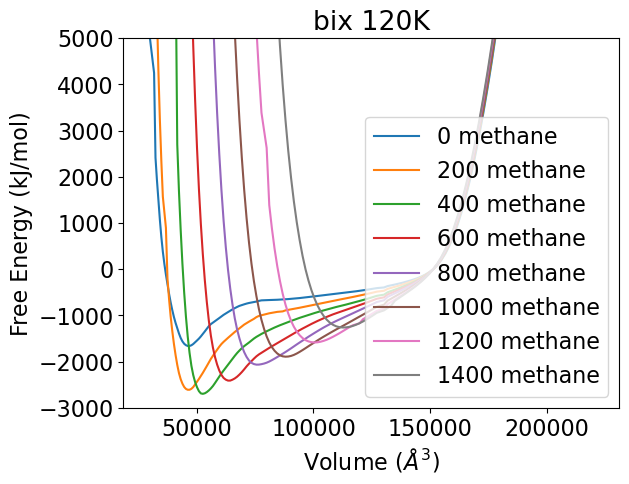

0 methane: 17    47763.773
55    84504.726
Name: volume, dtype: float64, [-1648.65286917  -734.44015228]
Energy Well Difference: -914.2127168854224
200 methane: 18    48558.0
Name: volume, dtype: float64, [-2218.56304611]
400 methane: 24    56105.819
Name: volume, dtype: float64, [-2079.31340737]
600 methane: 32    70356.619
Name: volume, dtype: float64, [-1546.83870651]
800 methane: 43    89211.178
Name: volume, dtype: float64, [-1166.65691688]
1000 methane: 48    103047.88
Name: volume, dtype: float64, [-911.90535783]
1200 methane: 48    118246.07
Name: volume, dtype: float64, [-674.00938732]
1400 methane: 50    131738.26
Name: volume, dtype: float64, [-416.6168597]


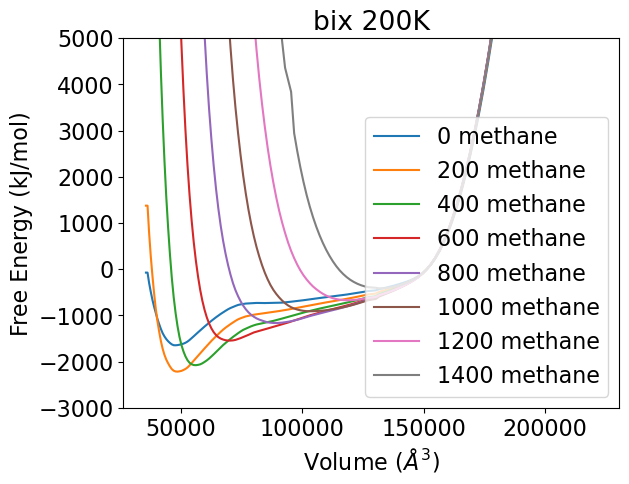

dict_keys([0, 200, 400, 600, 800, 1000, 1200])

0 methane: 12    48558.0
Name: volume, dtype: float64, [-2088.21511157]
200 methane: 13    50172.77
Name: volume, dtype: float64, [-2114.45431825]
400 methane: 12    60618.388
Name: volume, dtype: float64, [-1098.79543438]
600 methane: 25    92853.45
Name: volume, dtype: float64, [-479.69454959]
800 methane: 32    122635.72
Name: volume, dtype: float64, [-332.05471742]
1000 methane: 32    134869.62
Name: volume, dtype: float64, [-163.27290213]
1200 methane: 32    144560.64
Name: volume, dtype: float64, [-61.71736339]


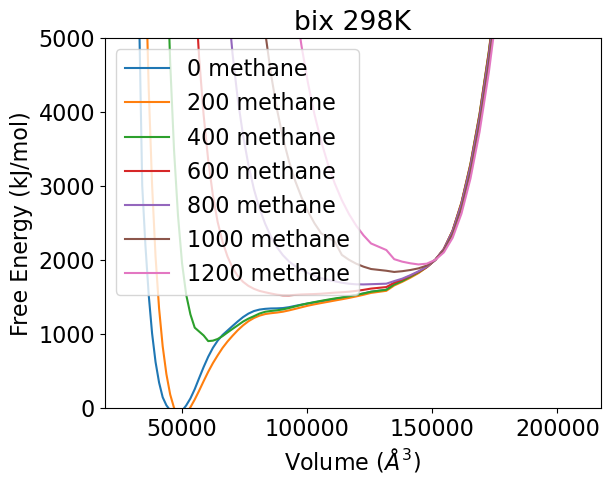

dict_keys([0, 200, 400, 600, 800, 1000, 1200, 1400])

0 methane: 17    47763.773
58    88018.599
Name: volume, dtype: float64, [-2127.11345494  -704.75898693]
Energy Well Difference: -1422.3544680106884
200 methane: 19    50993.409
55    88018.599
Name: volume, dtype: float64, [-1504.46419138  -571.96750078]
Energy Well Difference: -932.4966905979154
400 methane: 38     73469.108
54     95335.891
68    115378.620
Name: volume, dtype: float64, [-113.20035401 -290.83347739 -301.74518423]
Energy Well Difference: 177.6331233739329
600 methane: 69    131738.26
Name: volume, dtype: float64, [-173.75022558]
800 methane: 69    142914.26
Name: volume, dtype: float64, [-73.3681062]
1000 methane: 66    147891.23
Name: volume, dtype: float64, [-25.09689482]
1200 methane: 62    151272.59
Name: volume, dtype: float64, [0.]
1400 methane: 50    152982.43
Name: volume, dtype: float64, [-17.72043789]


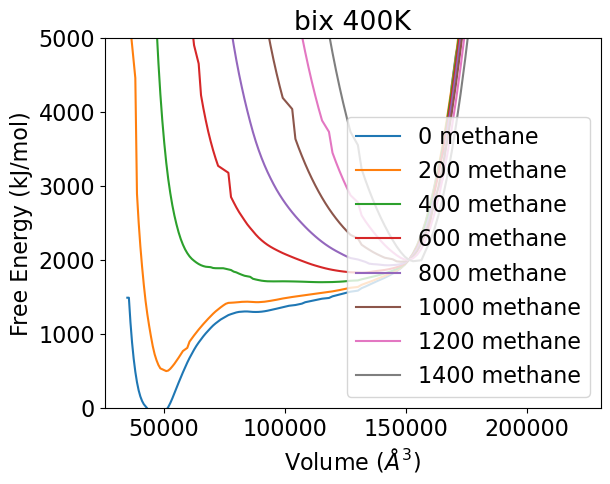

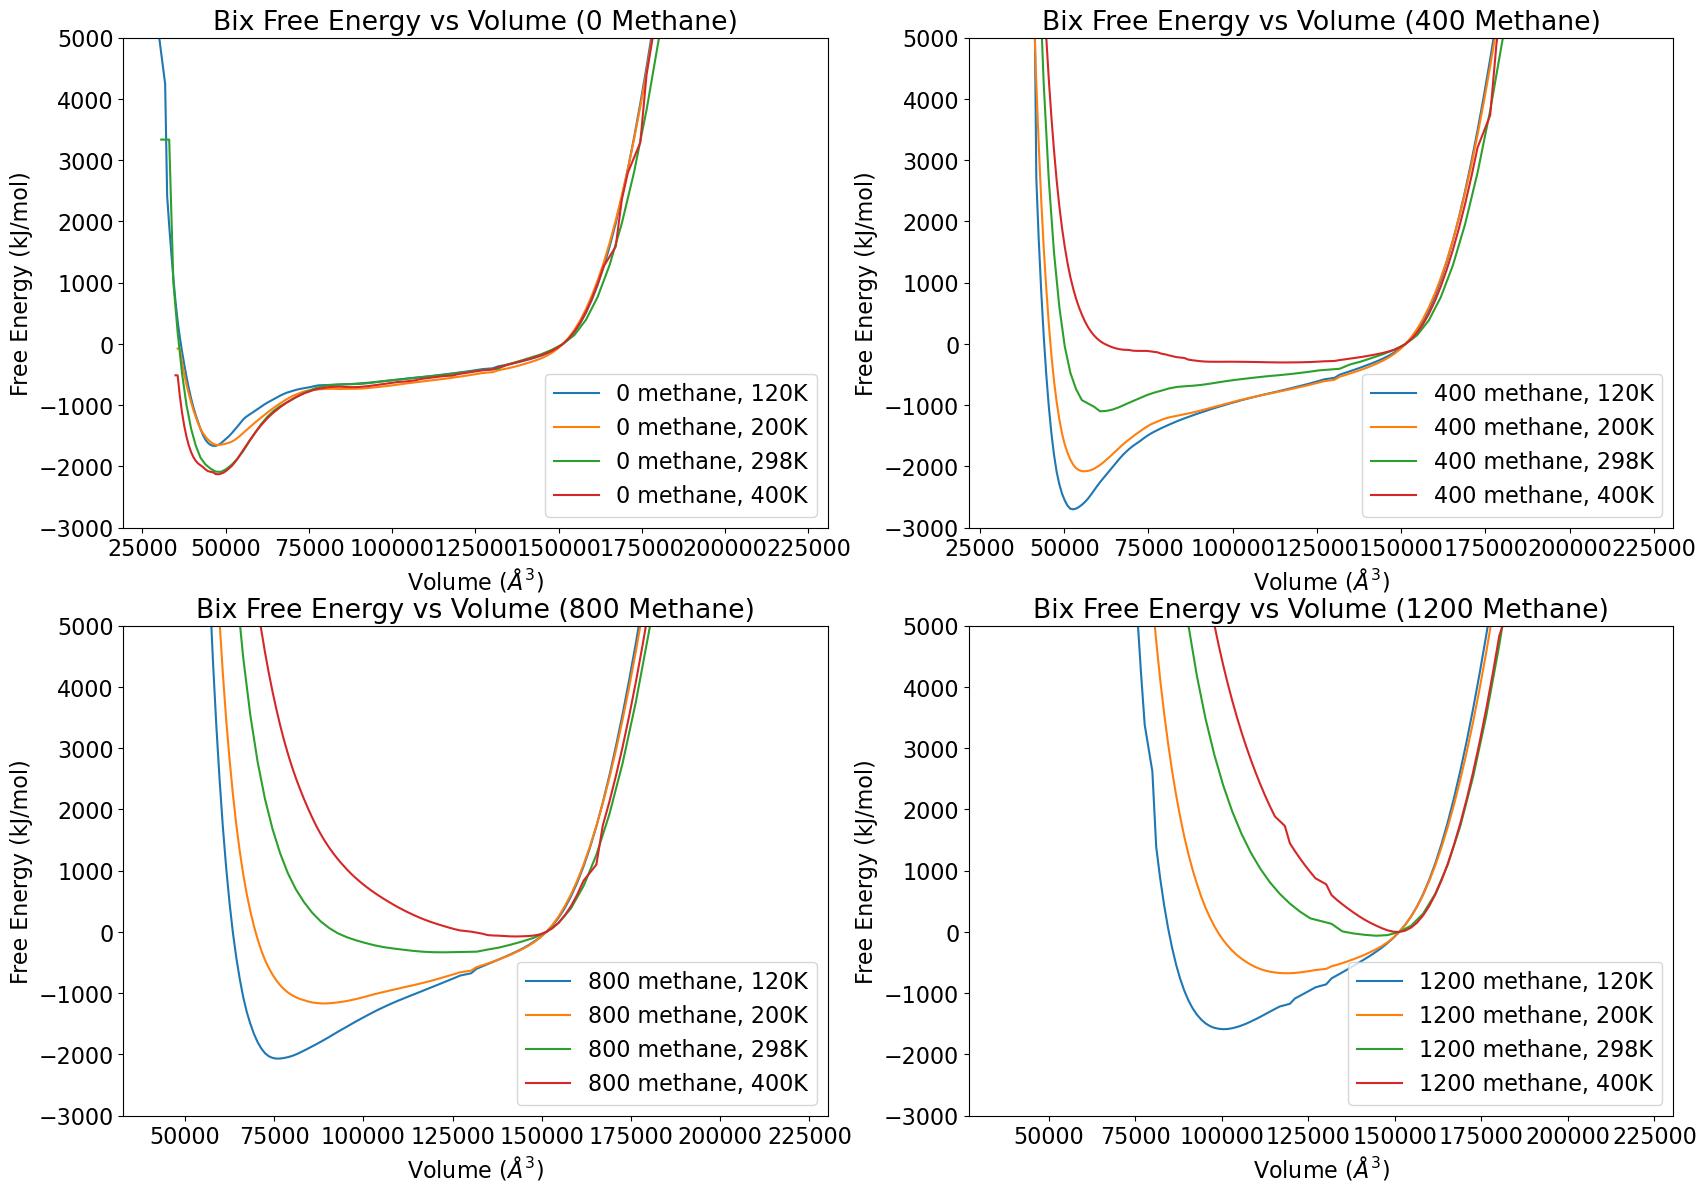

In [33]:
# Read in free energies and volumes from each file in FreeEnergy_Sept_data using get_FE_profile

bix_120K_data_dict = {}
bix_200K_data_dict = {}
bix_298K_data_dict = {}
bix_400K_data_dict = {}

# 1. Read in the data
for file in os.listdir('FreeEnergy_Sept_data'):
    if file.endswith('.txt'):
        #print(file)
        df, free_eng = get_FE_profile('FreeEnergy_Sept_data/' + file, 151000)
        if 'bix' in file and '120K' in file:
            num_methane = int(file.split('_')[3].split('m')[0])
            bix_120K_data_dict[num_methane] = (df, free_eng)
        elif 'bix' in file and '200K' in file:
            num_methane = int(file.split('_')[3].split('m')[0])
            bix_200K_data_dict[num_methane] = (df, free_eng)
        elif 'bix' in file and '298K' in file:
            num_methane = int(file.split('_')[3].split('m')[0])
            bix_298K_data_dict[num_methane] = (df, free_eng)
        elif 'bix' in file and '400K' in file:
            num_methane = int(file.split('_')[3].split('m')[0])
            bix_400K_data_dict[num_methane] = (df, free_eng)
            print(file)

# Sort the data by number of methane molecules
bix_120K_data_dict = dict(sorted(bix_120K_data_dict.items()))
bix_200K_data_dict = dict(sorted(bix_200K_data_dict.items()))
bix_298K_data_dict = dict(sorted(bix_298K_data_dict.items()))
bix_400K_data_dict = dict(sorted(bix_400K_data_dict.items()))

# 2. Plot the data
fig, ax = plt.subplots()
for num_methane, (df, free_eng) in bix_120K_data_dict.items():
    ax.plot(df['volume'], free_eng, label=f'{num_methane} methane')
    masked_FE = free_eng[free_eng < 2500]
    minima_indices = argrelmin(masked_FE)
    # print the volume and free energy of the minima
    print(f'{num_methane} methane: {df["volume"][free_eng < 2500].iloc[minima_indices]}, {masked_FE[minima_indices]}')
    if len(minima_indices[0]) > 1:
        print(f'Energy Well Difference: {masked_FE[minima_indices[0][0]] - masked_FE[minima_indices[0][1]]}')

ax.legend()
ax.set_xlabel('Volume ($\AA^3$)')
ax.set_ylabel('Free Energy (kJ/mol)')
ax.set_ylim(-3000, 5000)
plt.title('bix 120K')
plt.savefig('bix_120K.png', dpi=400)
plt.show()

fig, ax = plt.subplots()
for num_methane, (df, free_eng) in bix_200K_data_dict.items():
    ax.plot(df['volume'], free_eng, label=f'{num_methane} methane')#, linestyle='--')
    masked_FE = free_eng[free_eng < 2500]
    minima_indices = argrelmin(masked_FE)
    # print the volume and free energy of the minima
    print(f'{num_methane} methane: {df["volume"][free_eng < 2500].iloc[minima_indices]}, {masked_FE[minima_indices]}')
    if len(minima_indices[0]) > 1:
        print(f'Energy Well Difference: {masked_FE[minima_indices[0][0]] - masked_FE[minima_indices[0][1]]}')

ax.legend()
ax.set_xlabel('Volume ($\AA^3$)')
ax.set_ylabel('Free Energy (kJ/mol)')
ax.set_ylim(-3000, 5000)
plt.title('bix 200K')
plt.savefig('bix_200K.png', dpi=400)
plt.show()

print(bix_298K_data_dict.keys())
print()
fig, ax = plt.subplots()
for num_methane, (df, free_eng) in bix_298K_data_dict.items():
    ax.plot(df['volume'], free_eng+2000, label=f'{num_methane} methane')#, linestyle=':')
    masked_FE = free_eng[free_eng < 2500]
    minima_indices = argrelmin(masked_FE)
    # print the volume and free energy of the minima
    print(f'{num_methane} methane: {df["volume"][free_eng < 2500].iloc[minima_indices]}, {masked_FE[minima_indices]}')
    if len(minima_indices[0]) > 1:
        print(f'Energy Well Difference: {masked_FE[minima_indices[0][0]] - masked_FE[minima_indices[0][1]]}')

ax.legend()
ax.set_xlabel('Volume ($\AA^3$)')
ax.set_ylabel('Free Energy (kJ/mol)')
ax.set_ylim(0, 5000)
plt.title('bix 298K')
plt.savefig('bix_298K.png', dpi=400)
plt.show()

print(bix_400K_data_dict.keys())
print()
fig, ax = plt.subplots()
for num_methane, (df, free_eng) in bix_400K_data_dict.items():
    ax.plot(df['volume'], free_eng+2000, label=f'{num_methane} methane')#, linestyle=':')
    masked_FE = free_eng[free_eng < 2500]
    minima_indices = argrelmin(masked_FE)
    # print the volume and free energy of the minima
    print(f'{num_methane} methane: {df["volume"][free_eng < 2500].iloc[minima_indices]}, {masked_FE[minima_indices]}')
    if len(minima_indices[0]) > 1:
        print(f'Energy Well Difference: {masked_FE[minima_indices[0][0]] - masked_FE[minima_indices[0][1]]}')

ax.legend()
ax.set_xlabel('Volume ($\AA^3$)')
ax.set_ylabel('Free Energy (kJ/mol)')
ax.set_ylim(0, 5000)
plt.title('bix 400K')
plt.savefig('bix_400K.png', dpi=400)
plt.show()

# Plot by loading with temperature in legend, volume on x-axis, and free energy on y-axis
fig, ax = plt.subplots(2, 2, figsize=(20, 14))

for T in [120, 200, 298, 400]:
    for num_methane, (df, free_eng) in eval(f'bix_{T}K_data_dict').items():
        if num_methane == 0:
            ax[0,0].plot(df['volume'], free_eng, label=f'{num_methane} methane, {T}K')
        if num_methane == 400:
            ax[0,1].plot(df['volume'], free_eng, label=f'{num_methane} methane, {T}K')
        if num_methane == 800:
            ax[1,0].plot(df['volume'], free_eng, label=f'{num_methane} methane, {T}K')
        if num_methane == 1200:
            ax[1,1].plot(df['volume'], free_eng, label=f'{num_methane} methane, {T}K')

ax[0,0].legend(); ax[0,1].legend(); ax[1,0].legend(); ax[1,1].legend()
ax[0,0].set_xlabel('Volume ($\AA^3$)'); ax[0,1].set_xlabel('Volume ($\AA^3$)'); ax[1,0].set_xlabel('Volume ($\AA^3$)'); ax[1,1].set_xlabel('Volume ($\AA^3$)')
ax[0,0].set_ylabel('Free Energy (kJ/mol)'); ax[0,1].set_ylabel('Free Energy (kJ/mol)'); ax[1,0].set_ylabel('Free Energy (kJ/mol)'); ax[1,1].set_ylabel('Free Energy (kJ/mol)')
ax[0,0].set_ylim(-3000, 5000); ax[0,1].set_ylim(-3000, 5000); ax[1,0].set_ylim(-3000, 5000); ax[1,1].set_ylim(-3000, 5000)

ax[0,0].set_title('Bix Free Energy vs Volume (0 Methane)')
ax[0,1].set_title('Bix Free Energy vs Volume (400 Methane)')
ax[1,0].set_title('Bix Free Energy vs Volume (800 Methane)')
ax[1,1].set_title('Bix Free Energy vs Volume (1200 Methane)')



plt.savefig('Bix_Free_Energy_vs_Volume_by_Loading_and_Temperature.png', dpi=400)
plt.show()

pressures_Dabco_400K_0mol.txt
pressures_Dabco_400K_200mol.txt
pressures_Dabco_400K_400mol.txt
pressures_Dabco_400K_600mol.txt
pressures_Dabco_400K_800mol.txt
0 methane: 30    66110.745
Name: volume, dtype: float64, [-2.47735911]
200 methane: 22    65134.595
Name: volume, dtype: float64, [0.]
400 methane: 22    65134.595
Name: volume, dtype: float64, [0.]
600 methane: 21    65134.595
Name: volume, dtype: float64, [0.]
800 methane: 19    67096.6
Name: volume, dtype: float64, [-160.92682172]


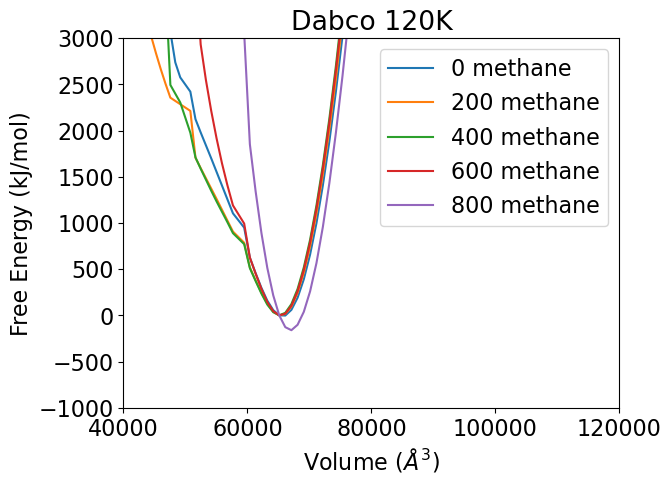

0 methane: 19    66110.745
Name: volume, dtype: float64, [-12.27159261]
200 methane: 19    65134.595
Name: volume, dtype: float64, [0.]
400 methane: 18    65134.595
Name: volume, dtype: float64, [0.]
600 methane: 17    66110.745
Name: volume, dtype: float64, [-23.25844576]
800 methane: 18    68092.206
Name: volume, dtype: float64, [-410.08677344]


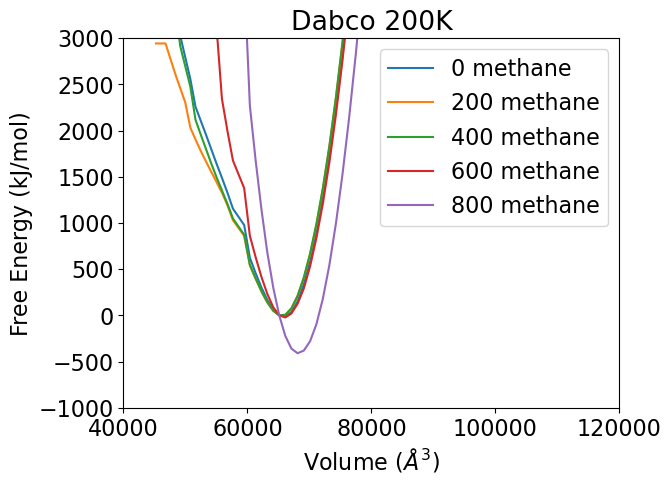

dict_keys([0, 200, 400, 600, 800])

0 methane: 18    66110.745
Name: volume, dtype: float64, [-11.04196207]
200 methane: 17    66110.745
Name: volume, dtype: float64, [-10.97192141]
400 methane: 18    66110.745
Name: volume, dtype: float64, [-26.19579653]
600 methane: 16    67096.6
Name: volume, dtype: float64, [-130.23136561]
800 methane: 18    69097.613
Name: volume, dtype: float64, [-824.09533155]


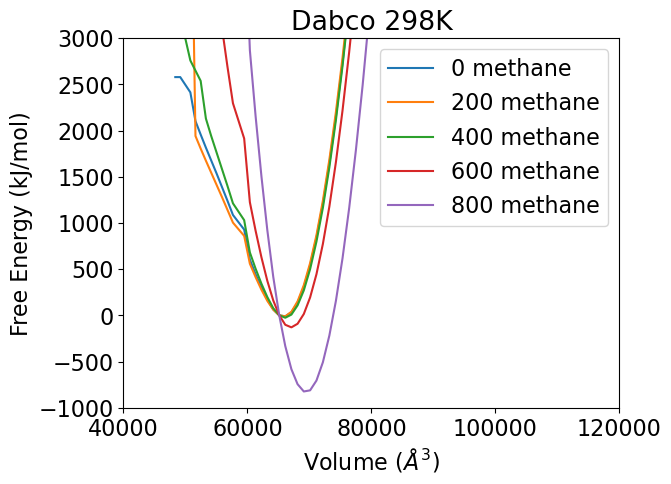

dict_keys([0, 200, 400, 600, 800])

0 methane: 11    66110.745
Name: volume, dtype: float64, [-17.66051152]
200 methane: 13    66110.745
Name: volume, dtype: float64, [-20.41220965]
400 methane: 15    67096.6
Name: volume, dtype: float64, [-147.20198246]
600 methane: 16    68092.206
Name: volume, dtype: float64, [-257.8597582]
800 methane: 15    70112.869
Name: volume, dtype: float64, [-2422.104031]


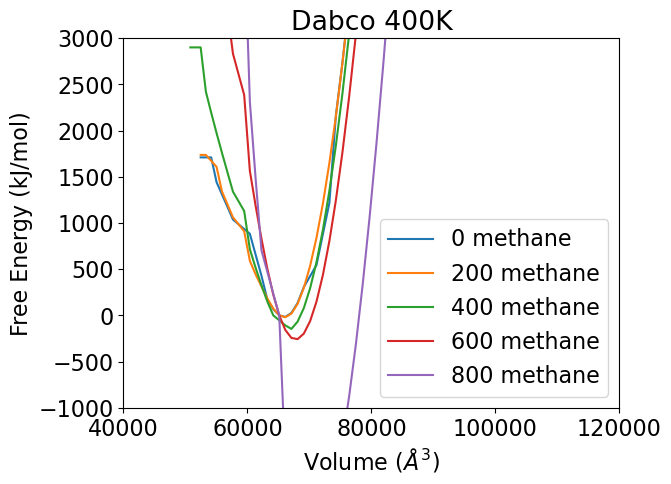

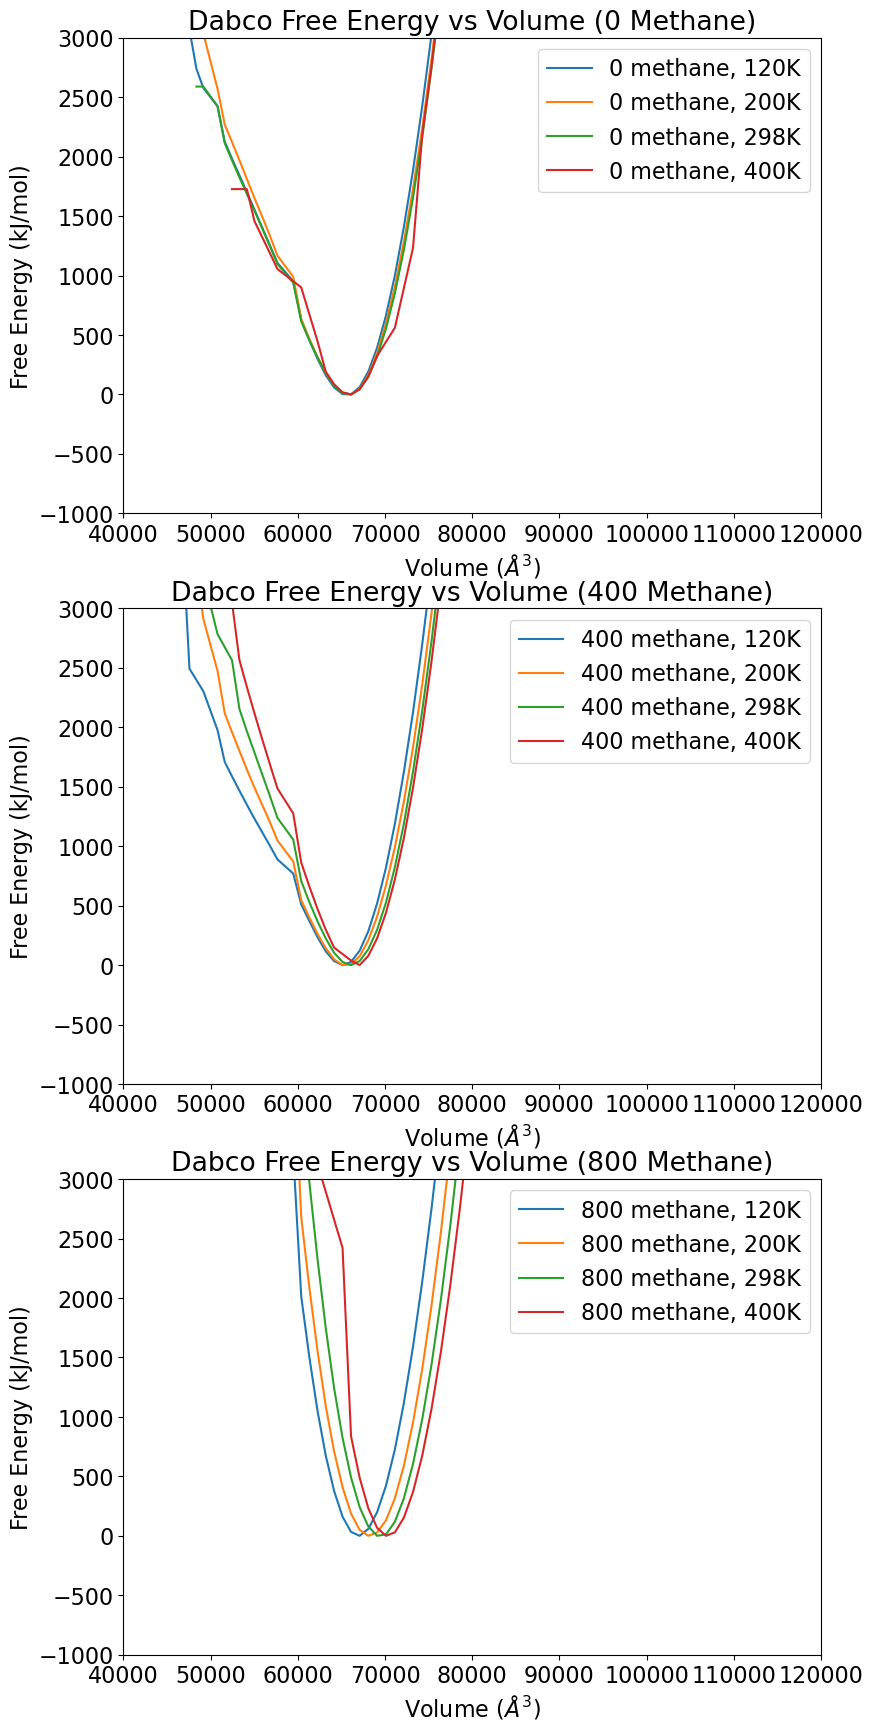

In [35]:
# Read in free energies and volumes from each file in FreeEnergy_Sept_data using get_FE_profile

Dabco_120K_data_dict = {}
Dabco_200K_data_dict = {}
Dabco_298K_data_dict = {}
Dabco_400K_data_dict = {}

# 1. Read in the data
for file in os.listdir('FreeEnergy_Sept_data'):
    if file.endswith('.txt'):
        #print(file)
        df, free_eng = get_FE_profile('FreeEnergy_Sept_data/' + file, 65000)
        if 'Dabco' in file and '120K' in file:
            num_methane = int(file.split('_')[3].split('m')[0])
            Dabco_120K_data_dict[num_methane] = (df, free_eng)
        elif 'Dabco' in file and '200K' in file:
            num_methane = int(file.split('_')[3].split('m')[0])
            Dabco_200K_data_dict[num_methane] = (df, free_eng)
        elif 'Dabco' in file and '298K' in file:
            num_methane = int(file.split('_')[3].split('m')[0])
            Dabco_298K_data_dict[num_methane] = (df, free_eng)
        elif 'Dabco' in file and '400K' in file:
            num_methane = int(file.split('_')[3].split('m')[0])
            Dabco_400K_data_dict[num_methane] = (df, free_eng)
            print(file)

# Sort the data by number of methane molecules
Dabco_120K_data_dict = dict(sorted(Dabco_120K_data_dict.items()))
Dabco_200K_data_dict = dict(sorted(Dabco_200K_data_dict.items()))
Dabco_298K_data_dict = dict(sorted(Dabco_298K_data_dict.items()))
Dabco_400K_data_dict = dict(sorted(Dabco_400K_data_dict.items()))

# 2. Plot the data
fig, ax = plt.subplots()
for num_methane, (df, free_eng) in Dabco_120K_data_dict.items():
    ax.plot(df['volume'], free_eng, label=f'{num_methane} methane')
    masked_FE = free_eng[free_eng < 2500]
    minima_indices = argrelmin(masked_FE)
    # print the volume and free energy of the minima
    print(f'{num_methane} methane: {df["volume"][free_eng < 2500].iloc[minima_indices]}, {masked_FE[minima_indices]}')
    if len(minima_indices[0]) > 1:
        print(f'Energy Well Difference: {masked_FE[minima_indices[0][0]] - masked_FE[minima_indices[0][1]]}')

ax.legend()
ax.set_xlabel('Volume ($\AA^3$)')
ax.set_ylabel('Free Energy (kJ/mol)')
ax.set_ylim(-1000, 3000)
ax.set_xlim(40000, 120000)
plt.title('Dabco 120K')
plt.savefig('Dabco_120K.png', dpi=400)
plt.show()

fig, ax = plt.subplots()
for num_methane, (df, free_eng) in Dabco_200K_data_dict.items():
    ax.plot(df['volume'], free_eng, label=f'{num_methane} methane')#, linestyle='--')
    masked_FE = free_eng[free_eng < 2500]
    minima_indices = argrelmin(masked_FE)
    # print the volume and free energy of the minima
    print(f'{num_methane} methane: {df["volume"][free_eng < 2500].iloc[minima_indices]}, {masked_FE[minima_indices]}')
    if len(minima_indices[0]) > 1:
        print(f'Energy Well Difference: {masked_FE[minima_indices[0][0]] - masked_FE[minima_indices[0][1]]}')

ax.legend()
ax.set_xlabel('Volume ($\AA^3$)')
ax.set_ylabel('Free Energy (kJ/mol)')
ax.set_ylim(-1000, 3000)
ax.set_xlim(40000, 120000)
plt.title('Dabco 200K')
plt.savefig('Dabco_200K.png', dpi=400)
plt.show()

print(Dabco_298K_data_dict.keys())
print()
fig, ax = plt.subplots()
for num_methane, (df, free_eng) in Dabco_298K_data_dict.items():
    ax.plot(df['volume'], free_eng, label=f'{num_methane} methane')#, linestyle=':')
    masked_FE = free_eng[free_eng < 2500]
    minima_indices = argrelmin(masked_FE)
    # print the volume and free energy of the minima
    print(f'{num_methane} methane: {df["volume"][free_eng < 2500].iloc[minima_indices]}, {masked_FE[minima_indices]}')
    if len(minima_indices[0]) > 1:
        print(f'Energy Well Difference: {masked_FE[minima_indices[0][0]] - masked_FE[minima_indices[0][1]]}')

ax.legend()
ax.set_xlabel('Volume ($\AA^3$)')
ax.set_ylabel('Free Energy (kJ/mol)')
ax.set_ylim(-1000, 3000)
ax.set_xlim(40000, 120000)
plt.title('Dabco 298K')
plt.savefig('Dabco_298K.png', dpi=400)
plt.show()

print(Dabco_400K_data_dict.keys())
print()
fig, ax = plt.subplots()
for num_methane, (df, free_eng) in Dabco_400K_data_dict.items():
    ax.plot(df['volume'], free_eng, label=f'{num_methane} methane')#, linestyle=':')
    masked_FE = free_eng[free_eng < 2500]
    minima_indices = argrelmin(masked_FE)
    # print the volume and free energy of the minima
    print(f'{num_methane} methane: {df["volume"][free_eng < 2500].iloc[minima_indices]}, {masked_FE[minima_indices]}')
    if len(minima_indices[0]) > 1:
        print(f'Energy Well Difference: {masked_FE[minima_indices[0][0]] - masked_FE[minima_indices[0][1]]}')

ax.legend()
ax.set_xlabel('Volume ($\AA^3$)')
ax.set_ylabel('Free Energy (kJ/mol)')
ax.set_ylim(-1000, 3000)
ax.set_xlim(40000, 120000)
plt.title('Dabco 400K')
plt.savefig('Dabco_400K.png', dpi=400)
plt.show()

# Plot by loading with temperature in legend, volume on x-axis, and free energy on y-axis
fig, ax = plt.subplots(3, 1, figsize=(9, 21))
for T in [120, 200, 298, 400]:
    for num_methane, (df, free_eng) in eval(f'Dabco_{T}K_data_dict').items():
        if num_methane == 0:
            ax[0].plot(df['volume'], free_eng - free_eng.min(), label=f'{num_methane} methane, {T}K')
        if num_methane == 400:
            ax[1].plot(df['volume'], free_eng - free_eng.min(), label=f'{num_methane} methane, {T}K')
        if num_methane == 800:
            ax[2].plot(df['volume'], free_eng - free_eng.min(), label=f'{num_methane} methane, {T}K')

ax[0].legend(); ax[1].legend(); ax[2].legend()
ax[0].set_xlabel('Volume ($\AA^3$)'); ax[1].set_xlabel('Volume ($\AA^3$)'); ax[2].set_xlabel('Volume ($\AA^3$)')
ax[0].set_ylabel('Free Energy (kJ/mol)'); ax[1].set_ylabel('Free Energy (kJ/mol)'); ax[2].set_ylabel('Free Energy (kJ/mol)')
ax[0].set_ylim(-1000, 3000); ax[1].set_ylim(-1000, 3000); ax[2].set_ylim(-1000, 3000)
ax[0].set_xlim(40000, 120000); ax[1].set_xlim(40000, 120000); ax[2].set_xlim(40000, 120000)
ax[0].set_title('Dabco Free Energy vs Volume (0 Methane)')
ax[1].set_title('Dabco Free Energy vs Volume (400 Methane)')
ax[2].set_title('Dabco Free Energy vs Volume (800 Methane)')
#plt.title('Dabco Free Energy vs Volume by Loading and Temperature')
plt.savefig('Dabco_Free_Energy_vs_Volume_by_Loading_and_Temperature.png', dpi=400)
plt.show()

pressures_DUT-48_400K_0mol.txt
pressures_DUT-48_400K_200mol.txt
pressures_DUT-48_400K_400mol.txt
pressures_DUT-48_400K_600mol.txt
pressures_DUT-48_400K_800mol.txt
0 methane: 88    69375.867
Name: volume, dtype: float64, [-111.53890375]
200 methane: 82    69375.867
Name: volume, dtype: float64, [-124.60316341]
400 methane: 69    69375.867
Name: volume, dtype: float64, [-127.93934558]
600 methane: 63    69375.867
Name: volume, dtype: float64, [-143.13276787]
800 methane: 56    69375.867
Name: volume, dtype: float64, [-139.6047098]
1000 methane: 48    69375.867
Name: volume, dtype: float64, [-8.48496245]
-----------------------------------------
Minima indices: (array([5], dtype=int64),)
Free energy: [-8.48496245]
Volume: 5    32431.24
Name: volume, dtype: float64
-----------------------------------------


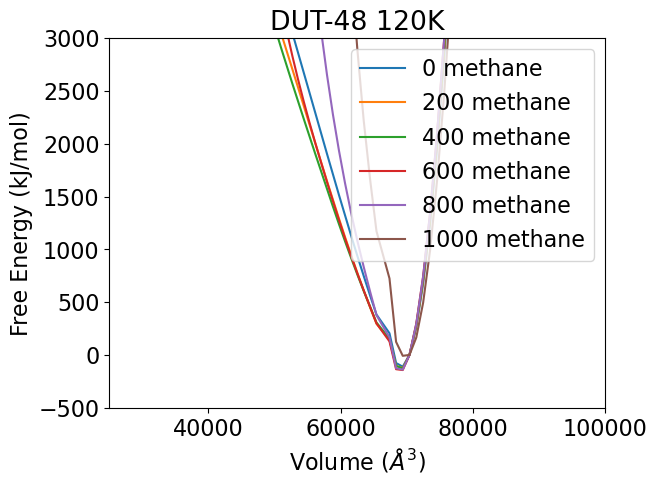

0 methane: 87    69375.867
Name: volume, dtype: float64, [-124.30498643]
200 methane: 82    69375.867
Name: volume, dtype: float64, [-136.06869758]
400 methane: 68    69375.867
Name: volume, dtype: float64, [-139.65842271]
600 methane: 61    69375.867
Name: volume, dtype: float64, [-134.46108666]
800 methane: 55    69375.867
Name: volume, dtype: float64, [-93.08276266]
1000 methane: 47    70393.839
Name: volume, dtype: float64, [0.]


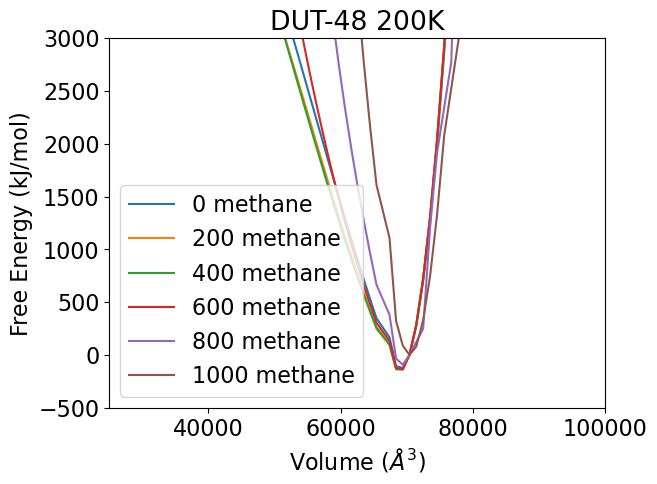

dict_keys([0, 200, 400, 600, 800, 1000])

0 methane: 88    69375.867
Name: volume, dtype: float64, [-138.94864963]
200 methane: 78    68367.757
Name: volume, dtype: float64, [-152.2494712]
400 methane: 69    68367.757
Name: volume, dtype: float64, [-145.24685187]
600 methane: 61    69375.867
Name: volume, dtype: float64, [-118.29075664]
800 methane: 55    69375.867
Name: volume, dtype: float64, [-39.63939544]
1000 methane: 46    71421.72
Name: volume, dtype: float64, [-13.25113645]


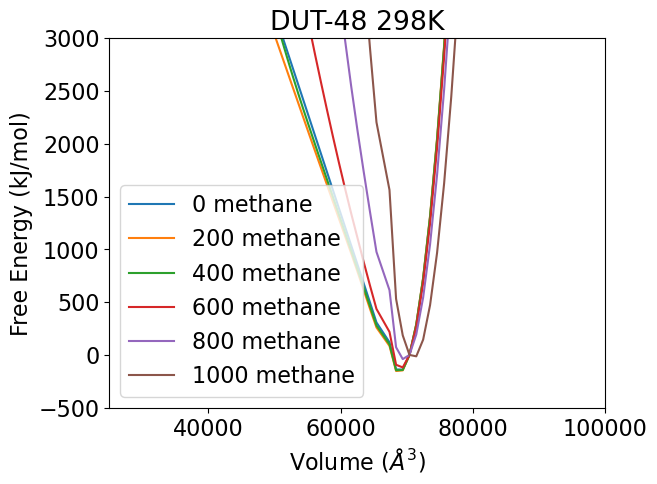

dict_keys([0, 200, 400, 600, 800])

0 methane: 84    68367.757
Name: volume, dtype: float64, [-170.0930758]
200 methane: 77    68367.757
Name: volume, dtype: float64, [-172.03608039]
400 methane: 64    68367.757
Name: volume, dtype: float64, [-146.59810991]
600 methane: 60    69375.867
Name: volume, dtype: float64, [-99.04734277]
800 methane: 53    70393.839
Name: volume, dtype: float64, [0.]


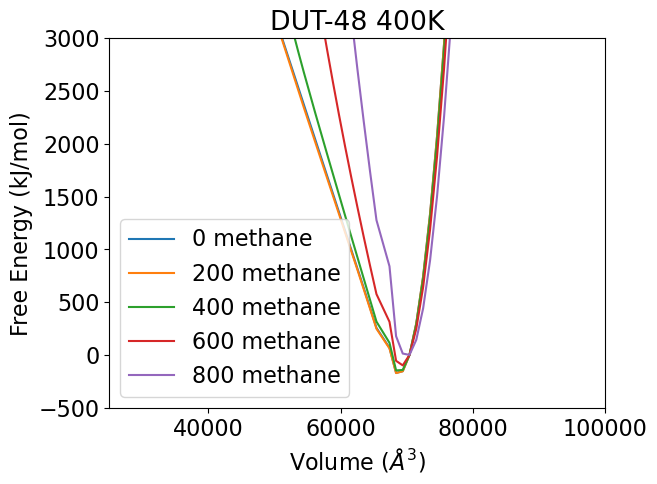

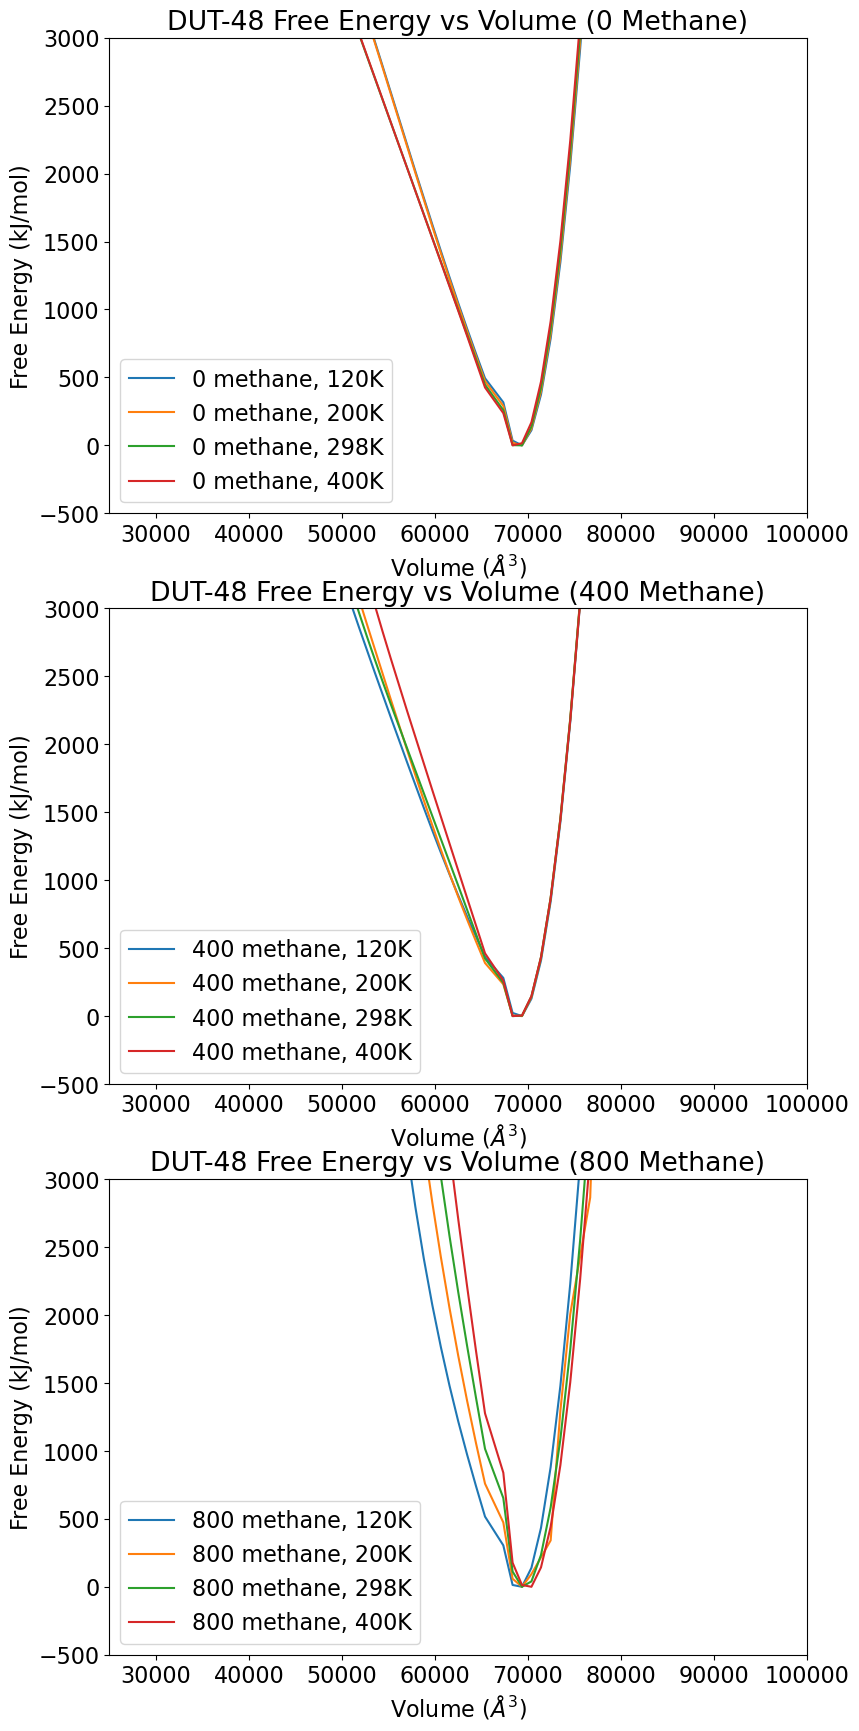

In [37]:
# Read in free energies and volumes from each file in FreeEnergy_Sept_data using get_FE_profile

DUT48_120K_data_dict = {}
DUT48_200K_data_dict = {}
DUT48_298K_data_dict = {}
DUT48_400K_data_dict = {}

# 1. Read in the data
for file in os.listdir('FreeEnergy_Sept_data'):
    if file.endswith('.txt'):
        #print(file)
        df, free_eng = get_FE_profile('FreeEnergy_Sept_data/' + file, 70000)
        if 'DUT-48' in file and '120K' in file:
            num_methane = int(file.split('_')[3].split('m')[0])
            DUT48_120K_data_dict[num_methane] = (df, free_eng)
        elif 'DUT-48' in file and '200K' in file:
            num_methane = int(file.split('_')[3].split('m')[0])
            DUT48_200K_data_dict[num_methane] = (df, free_eng)
        elif 'DUT-48' in file and '298K' in file:
            num_methane = int(file.split('_')[3].split('m')[0])
            DUT48_298K_data_dict[num_methane] = (df, free_eng)
        elif 'DUT-48' in file and '400K' in file:
            num_methane = int(file.split('_')[3].split('m')[0])
            DUT48_400K_data_dict[num_methane] = (df, free_eng)
            print(file)

# Sort the data by number of methane molecules
DUT48_120K_data_dict = dict(sorted(DUT48_120K_data_dict.items()))
DUT48_200K_data_dict = dict(sorted(DUT48_200K_data_dict.items()))
DUT48_298K_data_dict = dict(sorted(DUT48_298K_data_dict.items()))
DUT48_400K_data_dict = dict(sorted(DUT48_400K_data_dict.items()))

# 2. Plot the data
fig, ax = plt.subplots()
for num_methane, (df, free_eng) in DUT48_120K_data_dict.items():
    ax.plot(df['volume'], free_eng, label=f'{num_methane} methane')
    masked_FE = free_eng[free_eng < 2500]
    minima_indices = argrelmin(masked_FE)
    # print the volume and free energy of the minima
    print(f'{num_methane} methane: {df["volume"][free_eng < 2500].iloc[minima_indices]}, {masked_FE[minima_indices]}')
    if len(minima_indices[0]) > 1:
        print(f'Energy Well Difference: {masked_FE[minima_indices[0][0]] - masked_FE[minima_indices[0][1]]}')

# Print the minima indices and the free energy and volume at those indices
print('-----------------------------------------')
print(f'Minima indices: {minima_indices}')
print(f'Free energy: {masked_FE[minima_indices]}')
print(f'Volume: {df["volume"].iloc[minima_indices]}')
print('-----------------------------------------')

ax.legend()
ax.set_xlabel('Volume ($\AA^3$)')
ax.set_ylabel('Free Energy (kJ/mol)')
ax.set_ylim(-500, 3000)
ax.set_xlim(25000, 100000)
plt.title('DUT-48 120K')
plt.savefig('DUT48_120K.png', dpi=400)
plt.show()

fig, ax = plt.subplots()
for num_methane, (df, free_eng) in DUT48_200K_data_dict.items():
    ax.plot(df['volume'], free_eng, label=f'{num_methane} methane')#, linestyle='--')
    masked_FE = free_eng[free_eng < 2500]
    minima_indices = argrelmin(masked_FE)
    # print the volume and free energy of the minima
    print(f'{num_methane} methane: {df["volume"][free_eng < 2500].iloc[minima_indices]}, {masked_FE[minima_indices]}')
    if len(minima_indices[0]) > 1:
        print(f'Energy Well Difference: {masked_FE[minima_indices[0][0]] - masked_FE[minima_indices[0][1]]}')

ax.legend()
ax.set_xlabel('Volume ($\AA^3$)')
ax.set_ylabel('Free Energy (kJ/mol)')
ax.set_ylim(-500, 3000)
ax.set_xlim(25000, 100000)
plt.title('DUT-48 200K')
plt.savefig('DUT48_200K.png', dpi=400)
plt.show()

print(DUT48_298K_data_dict.keys())
print()
fig, ax = plt.subplots()
for num_methane, (df, free_eng) in DUT48_298K_data_dict.items():
    ax.plot(df['volume'], free_eng, label=f'{num_methane} methane')#, linestyle=':')
    masked_FE = free_eng[free_eng < 2500]
    minima_indices = argrelmin(masked_FE)
    # print the volume and free energy of the minima
    print(f'{num_methane} methane: {df["volume"][free_eng < 2500].iloc[minima_indices]}, {masked_FE[minima_indices]}')
    if len(minima_indices[0]) > 1:
        print(f'Energy Well Difference: {masked_FE[minima_indices[0][0]] - masked_FE[minima_indices[0][1]]}')

ax.legend()
ax.set_xlabel('Volume ($\AA^3$)')
ax.set_ylabel('Free Energy (kJ/mol)')
ax.set_ylim(-500, 3000)
ax.set_xlim(25000, 100000)
plt.title('DUT-48 298K')
plt.savefig('DUT48_298K.png', dpi=400)
plt.show()

print(DUT48_400K_data_dict.keys())
print()
fig, ax = plt.subplots()
for num_methane, (df, free_eng) in DUT48_400K_data_dict.items():
    ax.plot(df['volume'], free_eng, label=f'{num_methane} methane')#, linestyle=':')
    masked_FE = free_eng[free_eng < 2500]
    minima_indices = argrelmin(masked_FE)
    # print the volume and free energy of the minima
    print(f'{num_methane} methane: {df["volume"][free_eng < 2500].iloc[minima_indices]}, {masked_FE[minima_indices]}')
    if len(minima_indices[0]) > 1:
        print(f'Energy Well Difference: {masked_FE[minima_indices[0][0]] - masked_FE[minima_indices[0][1]]}')

ax.legend()
ax.set_xlabel('Volume ($\AA^3$)')
ax.set_ylabel('Free Energy (kJ/mol)')
ax.set_ylim(-500, 3000)
ax.set_xlim(25000, 100000)
plt.title('DUT-48 400K')
plt.savefig('DUT48_400K.png', dpi=400)
plt.show()

# Plot by loading with temperature in legend, volume on x-axis, and free energy on y-axis
fig, ax = plt.subplots(3, 1, figsize=(9, 21))
for T in [120, 200, 298, 400]:
    for num_methane, (df, free_eng) in eval(f'DUT48_{T}K_data_dict').items():
        if num_methane == 0:
            ax[0].plot(df['volume'], free_eng - free_eng.min(), label=f'{num_methane} methane, {T}K')
        if num_methane == 400:
            ax[1].plot(df['volume'], free_eng - free_eng.min(), label=f'{num_methane} methane, {T}K')
        if num_methane == 800:
            ax[2].plot(df['volume'], free_eng - free_eng.min(), label=f'{num_methane} methane, {T}K')

ax[0].legend(); ax[1].legend(); ax[2].legend()
ax[0].set_xlabel('Volume ($\AA^3$)'); ax[1].set_xlabel('Volume ($\AA^3$)'); ax[2].set_xlabel('Volume ($\AA^3$)')
ax[0].set_ylabel('Free Energy (kJ/mol)'); ax[1].set_ylabel('Free Energy (kJ/mol)'); ax[2].set_ylabel('Free Energy (kJ/mol)')
ax[0].set_ylim(-500, 3000); ax[1].set_ylim(-500, 3000); ax[2].set_ylim(-500, 3000)
ax[0].set_xlim(25000, 100000); ax[1].set_xlim(25000, 100000); ax[2].set_xlim(25000, 100000)
ax[0].set_title('DUT-48 Free Energy vs Volume (0 Methane)')
ax[1].set_title('DUT-48 Free Energy vs Volume (400 Methane)')
ax[2].set_title('DUT-48 Free Energy vs Volume (800 Methane)')
plt.savefig('DUT-48_Free_Energy_vs_Volume_by_Loading_and_Temperature.png', dpi=400)
plt.show()

pressures_DUT-49_298K_0mol.txt
pressures_DUT-49_298K_1000mol.txt
pressures_DUT-49_298K_1200mol.txt
pressures_DUT-49_298K_200mol.txt
pressures_DUT-49_298K_400mol.txt
pressures_DUT-49_298K_600mol.txt
pressures_DUT-49_298K_800mol.txt
pressures_DUT-49_400K_0mol.txt
pressures_DUT-49_400K_1000mol.txt
pressures_DUT-49_400K_1200mol.txt
pressures_DUT-49_400K_200mol.txt
pressures_DUT-49_400K_400mol.txt
pressures_DUT-49_400K_600mol.txt
pressures_DUT-49_400K_800mol.txt
0 methane: 53      50572.143
105    106363.710
Name: volume, dtype: float64, [1050.28804542  -23.67974986]
Energy Well Difference: 1073.9677952736783
maxima_indices: (array([9], dtype=int64),)
g* left to right: 187.62112175434777
g* right to left: 1261.5889170280261
200 methane: 52      49756.047
105    106363.710
Name: volume, dtype: float64, [436.73390298 -17.49439648]
Energy Well Difference: 454.2282994592824
maxima_indices: (array([18], dtype=int64),)
g* left to right: 492.64871723191027
g* right to left: 946.8770166911927
400 m

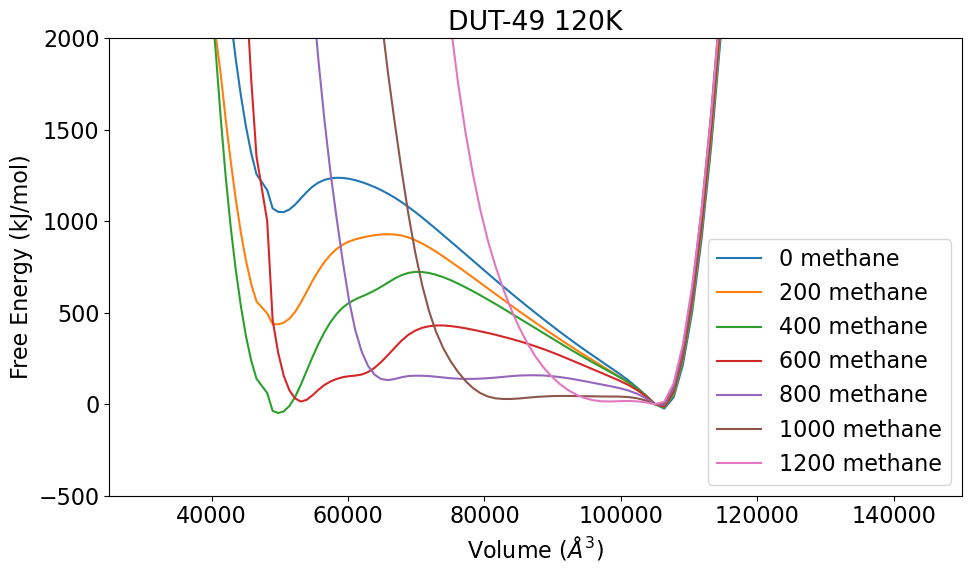

0 methane: 53      50572.143
105    106363.710
Name: volume, dtype: float64, [1098.73903871  -16.39957508]
Energy Well Difference: 1115.1386137850586
maxima_indices: (array([9], dtype=int64),)
g* left to right: 171.7826607419447
g* right to left: 1286.9212745270033
200 methane: 51      49756.047
104    106363.710
Name: volume, dtype: float64, [618.86908487 -10.4870919 ]
Energy Well Difference: 629.3561767639112
maxima_indices: (array([14], dtype=int64),)
g* left to right: 350.708567614005
g* right to left: 980.0647443779162
400 methane: 53      50572.143
105    106363.710
Name: volume, dtype: float64, [368.55339438  -8.3440287 ]
Energy Well Difference: 376.89742307621054
maxima_indices: (array([21], dtype=int64),)
g* left to right: 369.874459959683
g* right to left: 746.7718830358936
600 methane: 61     65842.86
96    106363.71
Name: volume, dtype: float64, [622.83399707  -6.95399656]
Energy Well Difference: 629.7879936310928
maxima_indices: (array([3], dtype=int64),)
g* left to right:

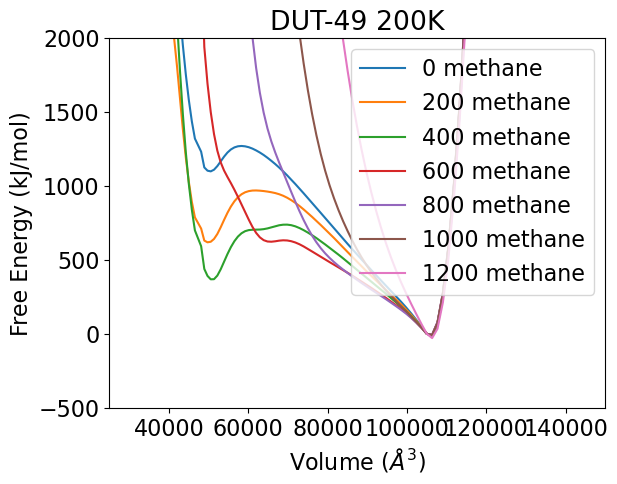


0 methane: 53      50572.143
105    106363.710
Name: volume, dtype: float64, [1168.41301666   -4.69029137]
Energy Well Difference: 1173.1033080303514
maxima_indices: (array([9], dtype=int64),)
g* left to right: 150.91850667402468
g* right to left: 1324.021814704376
200 methane: 53      50572.143
105    106363.710
Name: volume, dtype: float64, [930.71411566  -2.16374241]
Energy Well Difference: 932.8778580741055
maxima_indices: (array([10], dtype=int64),)
g* left to right: 226.30276825273177
g* right to left: 1159.1806263268372
400 methane: 52      52231.009
102    106363.710
Name: volume, dtype: float64, [1184.2271614   -2.6512246]
Energy Well Difference: 1186.8783860024996
maxima_indices: (array([5], dtype=int64),)
g* left to right: 63.94080760158249
g* right to left: 1250.819193604082
600 methane: 91    106363.71
Name: volume, dtype: float64, [-6.72712245]
800 methane: 89    106363.71
Name: volume, dtype: float64, [-16.18629672]
1000 methane: 82    106363.71
Name: volume, dtype: flo

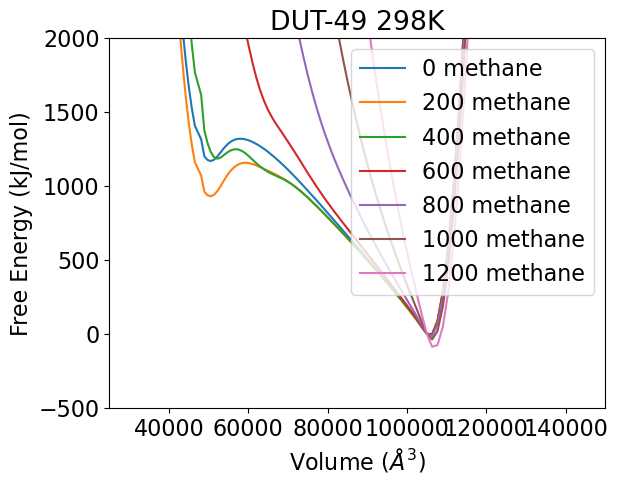

{0: 1073.9677952736783, 200: 454.2282994592824, 400: -30.53151360739139, 600: 26.021759422961622, 800: 134.53668574790936, 1000: 28.668484193156473, 1200: 15.1230077825021}
{0: 1115.1386137850586, 200: 629.3561767639112, 400: 376.89742307621054, 600: 629.7879936310928, 800: nan, 1000: nan, 1200: nan}
{0: 1173.1033080303514, 200: 932.8778580741055, 400: 1186.8783860024996, 600: nan, 800: nan, 1000: nan, 1200: nan}


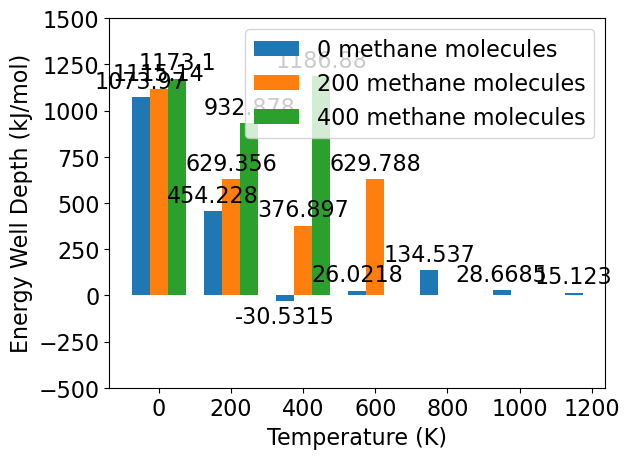

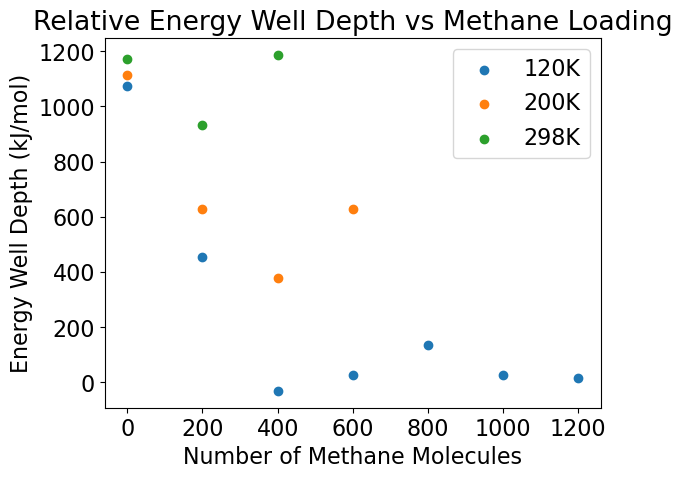

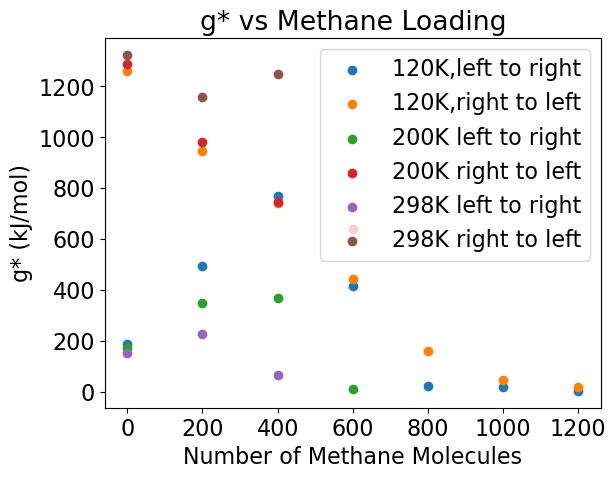

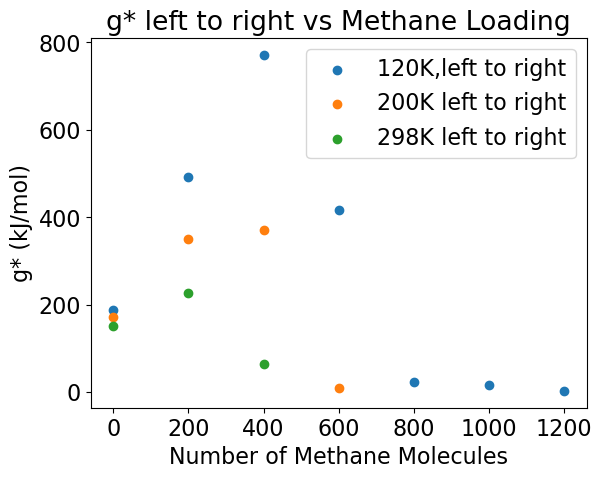

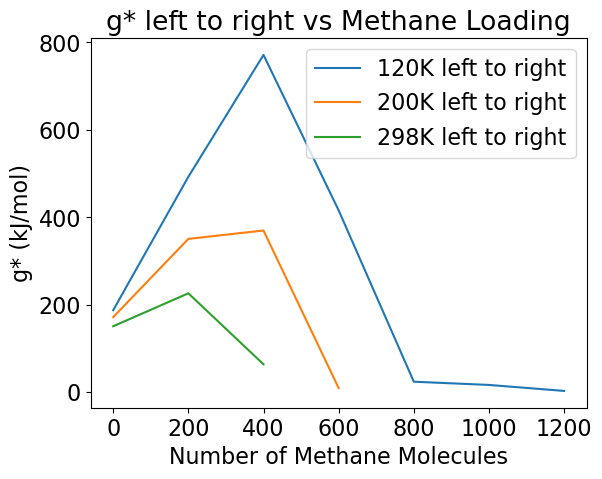

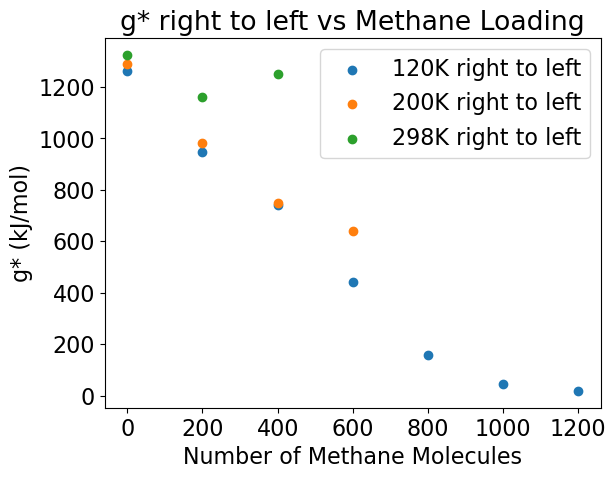

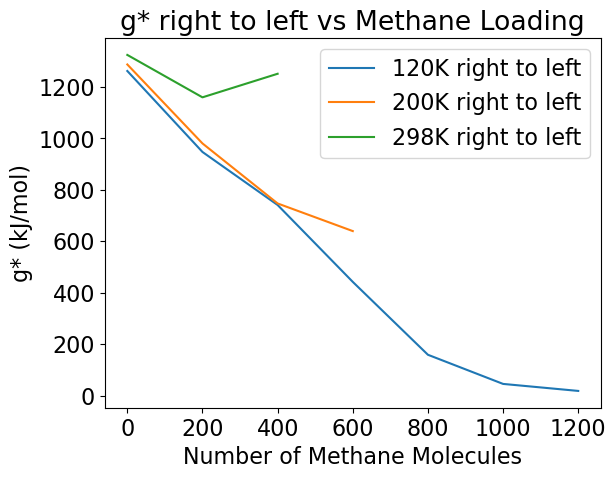

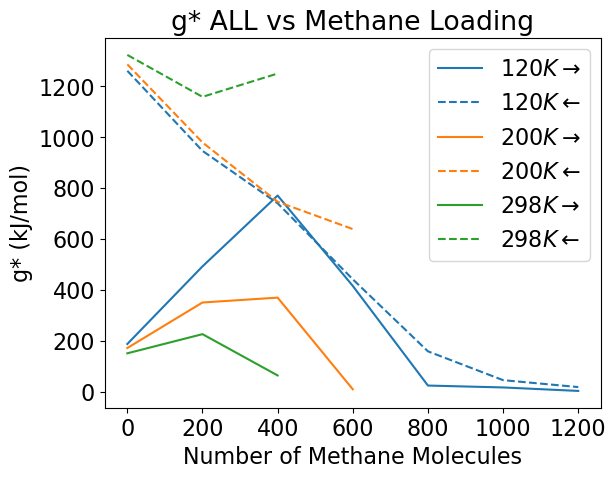

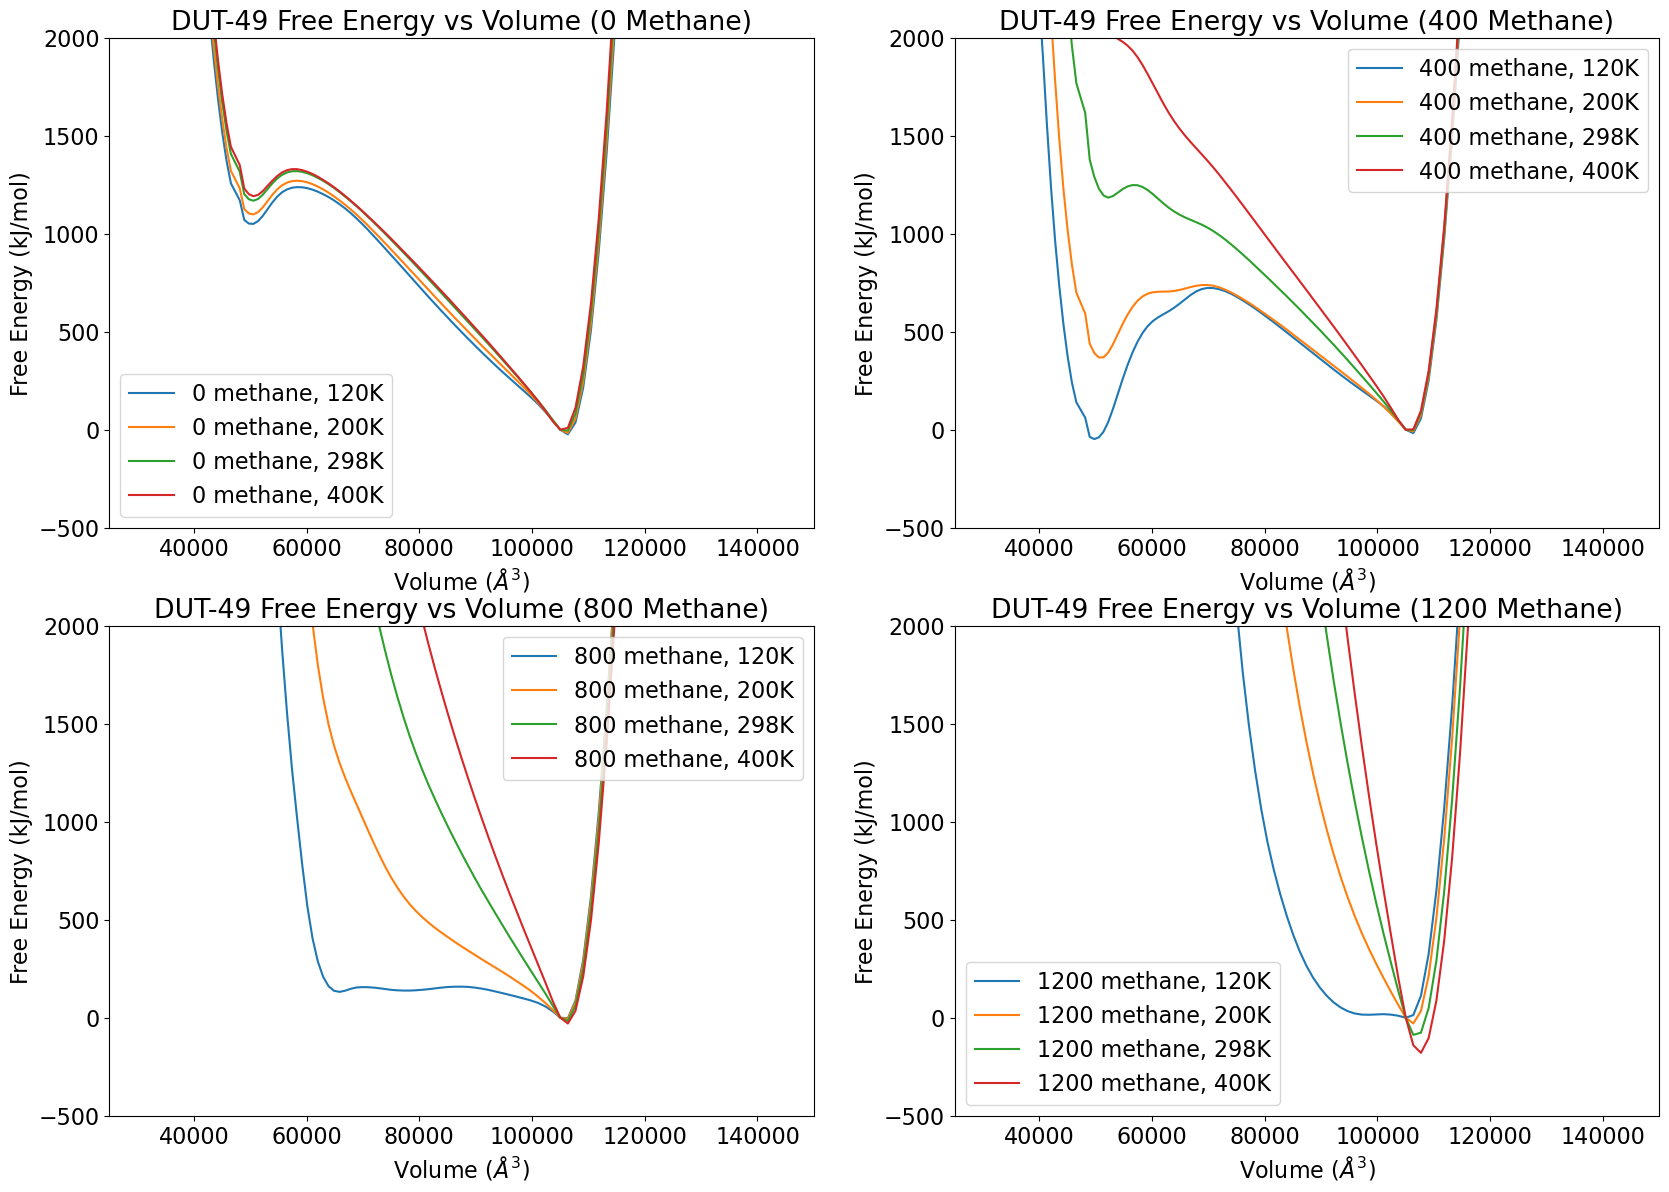

In [44]:
# Read in free energies and volumes from each file in FreeEnergy_Sept_data using get_FE_profile

DUT49_120K_data_dict = {}
DUT49_200K_data_dict = {}
DUT49_298K_data_dict = {}
DUT49_400K_data_dict = {}
DUT49_120K_depth_dict = {}
DUT49_200K_depth_dict = {}
DUT49_298K_depth_dict = {}
del_g_star_ltor_methane = {120:[], 200:[], 298:[]}
del_g_star_rtol_dict = {120:[], 200:[], 298:[]}
del_g_star_rtol_methane = {120:[], 200:[], 298:[]}
del_g_star_ltor_dict = {120:[], 200:[], 298:[]}

# 1. Read in the data
for file in os.listdir('FreeEnergy_Sept_data'):
    if file.endswith('.txt'):
        #print(file)
        df, free_eng = get_FE_profile('FreeEnergy_Sept_data/' + file, 105000)
        if 'DUT-49' in file and '120K' in file:
            num_methane = int(file.split('_')[3].split('m')[0])
            DUT49_120K_data_dict[num_methane] = (df, free_eng)
        elif 'DUT-49' in file and '200K' in file:
            num_methane = int(file.split('_')[3].split('m')[0])
            DUT49_200K_data_dict[num_methane] = (df, free_eng)
        elif 'DUT-49' in file and '298K' in file:
            num_methane = int(file.split('_')[3].split('m')[0])
            DUT49_298K_data_dict[num_methane] = (df, free_eng)
            print(file)
        elif 'DUT-49' in file and '400K' in file:
            num_methane = int(file.split('_')[3].split('m')[0])
            DUT49_400K_data_dict[num_methane] = (df, free_eng)
            print(file)

# Sort the data by number of methane molecules
DUT49_120K_data_dict = dict(sorted(DUT49_120K_data_dict.items()))
DUT49_200K_data_dict = dict(sorted(DUT49_200K_data_dict.items()))
DUT49_298K_data_dict = dict(sorted(DUT49_298K_data_dict.items()))
DUT49_400K_data_dict = dict(sorted(DUT49_400K_data_dict.items()))

# 2. Plot the data
fig, ax = plt.subplots(figsize=(10, 6))
for num_methane, (df, free_eng) in DUT49_120K_data_dict.items():
    ax.plot(df['volume'], free_eng, label=f'{num_methane} methane')
    masked_FE = free_eng[free_eng < 2000]
    minima_indices = argrelmin(masked_FE)
    len_diff = len(free_eng) - len(masked_FE)
    # print the volume and free energy of the minima
    print(f'{num_methane} methane: {df["volume"][free_eng < 2000].iloc[minima_indices]}, {masked_FE[minima_indices]}')
    if len(minima_indices[0]) > 1:
        print(f'Energy Well Difference: {masked_FE[minima_indices[0][0]] - masked_FE[minima_indices[0][-1]]}')
        DUT49_120K_depth_dict[num_methane] = masked_FE[minima_indices[0][0]] - masked_FE[minima_indices[0][-1]]
        # find maximum between the two minima
        maxima_indices = argrelmax(masked_FE[minima_indices[0][0]:minima_indices[0][-1]])
        print(f'maxima_indices: {maxima_indices}')
        g_star_ltor = -(masked_FE[minima_indices[0][0]] - masked_FE[minima_indices[0][0]:minima_indices[0][-1]][maxima_indices[0][0]])
        g_star_rtol = -(masked_FE[minima_indices[0][-1]] - masked_FE[minima_indices[0][0]:minima_indices[0][-1]][maxima_indices[0][0]])
        print(f'g* left to right: {g_star_ltor}')
        print(f'g* right to left: {g_star_rtol}')
        # save the g* values
        del_g_star_ltor_dict[120].append(g_star_ltor)
        del_g_star_rtol_dict[120].append(g_star_rtol)
        del_g_star_ltor_methane[120].append(num_methane)
        del_g_star_rtol_methane[120].append(num_methane)

ax.legend()
ax.set_xlabel('Volume ($\AA^3$)')
ax.set_ylabel('Free Energy (kJ/mol)')
ax.set_ylim(-500, 2000)
ax.set_xlim(25000, 150000)
plt.title('DUT-49 120K')
plt.tight_layout()
plt.savefig('DUT-49_120K_FE_profile.png', dpi=400)
plt.show()


fig, ax = plt.subplots()
for num_methane, (df, free_eng) in DUT49_200K_data_dict.items():
    ax.plot(df['volume'], free_eng, label=f'{num_methane} methane')#, linestyle='--')
    masked_FE = free_eng[free_eng < 2000]
    minima_indices = argrelmin(masked_FE)
    # print the volume and free energy of the minima
    print(f'{num_methane} methane: {df["volume"][free_eng < 2000].iloc[minima_indices]}, {masked_FE[minima_indices]}')
    if len(minima_indices[0]) > 1:
        print(f'Energy Well Difference: {masked_FE[minima_indices[0][0]] - masked_FE[minima_indices[0][1]]}')
        DUT49_200K_depth_dict[num_methane] = masked_FE[minima_indices[0][0]] - masked_FE[minima_indices[0][1]]
        # find maximum between the two minima
        maxima_indices = argrelmax(masked_FE[minima_indices[0][0]:minima_indices[0][1]])
        print(f'maxima_indices: {maxima_indices}')
        g_star_ltor = -(masked_FE[minima_indices[0][0]] - masked_FE[minima_indices[0][0]:minima_indices[0][1]][maxima_indices[0][0]])
        g_star_rtol = -(masked_FE[minima_indices[0][1]] - masked_FE[minima_indices[0][0]:minima_indices[0][1]][maxima_indices[0][0]])
        print(f'g* left to right: {g_star_ltor}')
        print(f'g* right to left: {g_star_rtol}')
        # save the g* values
        del_g_star_ltor_dict[200].append(g_star_ltor)
        del_g_star_rtol_dict[200].append(g_star_rtol)
        del_g_star_ltor_methane[200].append(num_methane)
        del_g_star_rtol_methane[200].append(num_methane)

ax.legend()
ax.set_xlabel('Volume ($\AA^3$)')
ax.set_ylabel('Free Energy (kJ/mol)')
ax.set_ylim(-500, 2000)
ax.set_xlim(25000, 150000)
plt.title('DUT-49 200K')
plt.savefig('DUT-49_200K_FE_profile.png', dpi=400)
plt.show()


print()
fig, ax = plt.subplots()
for num_methane, (df, free_eng) in DUT49_298K_data_dict.items():
    ax.plot(df['volume'], free_eng, label=f'{num_methane} methane')#, linestyle=':')
    masked_FE = free_eng[free_eng < 2000]
    minima_indices = argrelmin(masked_FE)
    # print the volume and free energy of the minima
    print(f'{num_methane} methane: {df["volume"][free_eng < 2000].iloc[minima_indices]}, {masked_FE[minima_indices]}')
    if len(minima_indices[0]) > 1:
        print(f'Energy Well Difference: {masked_FE[minima_indices[0][0]] - masked_FE[minima_indices[0][1]]}')
        DUT49_298K_depth_dict[num_methane] = masked_FE[minima_indices[0][0]] - masked_FE[minima_indices[0][1]]
        # find maximum between the two minima
        maxima_indices = argrelmax(masked_FE[minima_indices[0][0]:minima_indices[0][1]])
        print(f'maxima_indices: {maxima_indices}')
        g_star_ltor = -(masked_FE[minima_indices[0][0]] - masked_FE[minima_indices[0][0]:minima_indices[0][1]][maxima_indices[0][0]])
        g_star_rtol = -(masked_FE[minima_indices[0][1]] - masked_FE[minima_indices[0][0]:minima_indices[0][1]][maxima_indices[0][0]])
        print(f'g* left to right: {g_star_ltor}')
        print(f'g* right to left: {g_star_rtol}')
        # save the g* values
        del_g_star_ltor_dict[298].append(g_star_ltor)
        del_g_star_rtol_dict[298].append(g_star_rtol)
        del_g_star_ltor_methane[298].append(num_methane)
        del_g_star_rtol_methane[298].append(num_methane)

ax.legend()
ax.set_xlabel('Volume ($\AA^3$)')
ax.set_ylabel('Free Energy (kJ/mol)')
ax.set_ylim(-500, 2000)
ax.set_xlim(25000, 150000)
plt.title('DUT-49 298K')
plt.savefig('DUT-49_298K_FE_profile.png', dpi=400)
plt.show()


DUT49_200K_depth_dict[800] = np.nan
DUT49_200K_depth_dict[1000] = np.nan
DUT49_200K_depth_dict[1200] = np.nan
DUT49_298K_depth_dict[600] = np.nan
DUT49_298K_depth_dict[800] = np.nan
DUT49_298K_depth_dict[1000] = np.nan
DUT49_298K_depth_dict[1200] = np.nan
print(DUT49_120K_depth_dict)
print(DUT49_200K_depth_dict)
print(DUT49_298K_depth_dict)

# Plot the energy well differences for bipyridine grouped by temperature in a bar graph
fig, ax = plt.subplots()
depths = [DUT49_120K_depth_dict, DUT49_200K_depth_dict, DUT49_298K_depth_dict]
temps = [120, 200, 298]
x = np.arange(len(DUT49_120K_depth_dict.keys()))
width = 0.25
multiplier = 0

for depth_dict in depths:
    depth = depth_dict.values()
    methane_nums = depth_dict.keys()
    methane_num = list(methane_nums)[multiplier]
    offset = width * multiplier
    rects = ax.bar(x + offset, depth, width, label=f'{methane_num} methane molecules')
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.legend()
ax.set_xticks(x+width, list(methane_nums))
ax.set_ylabel('Energy Well Depth (kJ/mol)')
ax.set_xlabel('Temperature (K)')
ax.set_ylim(-500, 1500)
plt.show()

# scatter plot of methane loadings vs depth of energy well
fig, ax = plt.subplots()
ax.scatter(DUT49_120K_depth_dict.keys(), DUT49_120K_depth_dict.values(), label='120K')
ax.scatter(DUT49_200K_depth_dict.keys(), DUT49_200K_depth_dict.values(), label='200K')
ax.scatter(DUT49_298K_depth_dict.keys(), DUT49_298K_depth_dict.values(), label='298K')
ax.set_xlabel('Number of Methane Molecules')
ax.set_ylabel('Energy Well Depth (kJ/mol)')
ax.set_title(f'Relative Energy Well Depth vs Methane Loading')
ax.legend()
plt.savefig('DUT-49_Energy_Well_Depth_vs_Methane_Loading.png', dpi=400)
plt.show()

# scatter plot of methane loadings vs g* values
fig, ax = plt.subplots()
ax.scatter(del_g_star_ltor_methane[120], del_g_star_ltor_dict[120], label='120K,left to right')
ax.scatter(del_g_star_rtol_methane[120], del_g_star_rtol_dict[120], label='120K,right to left')
ax.scatter(del_g_star_ltor_methane[200], del_g_star_ltor_dict[200], label='200K left to right')
ax.scatter(del_g_star_rtol_methane[200], del_g_star_rtol_dict[200], label='200K right to left')
ax.scatter(del_g_star_ltor_methane[298], del_g_star_ltor_dict[298], label='298K left to right')
ax.scatter(del_g_star_rtol_methane[298], del_g_star_rtol_dict[298], label='298K right to left')
ax.set_xlabel('Number of Methane Molecules')
ax.set_ylabel('g* (kJ/mol)')
ax.set_title(f'g* vs Methane Loading')
ax.legend()
plt.show()

# scatter plot of methane loadings vs g* values (left to right)
fig, ax = plt.subplots()
ax.scatter(del_g_star_ltor_methane[120], del_g_star_ltor_dict[120], label='120K,left to right')
ax.scatter(del_g_star_ltor_methane[200], del_g_star_ltor_dict[200], label='200K left to right')
ax.scatter(del_g_star_ltor_methane[298], del_g_star_ltor_dict[298], label='298K left to right')
ax.set_xlabel('Number of Methane Molecules')
ax.set_ylabel('g* (kJ/mol)')
ax.set_title(f'g* left to right vs Methane Loading')
ax.legend()
plt.show()

# line plot of methane loadings vs g* values (left to right)
fig, ax = plt.subplots()
ax.plot(del_g_star_ltor_methane[120], del_g_star_ltor_dict[120], label='120K left to right')
ax.plot(del_g_star_ltor_methane[200], del_g_star_ltor_dict[200], label='200K left to right')
ax.plot(del_g_star_ltor_methane[298], del_g_star_ltor_dict[298], label='298K left to right')
ax.set_xlabel('Number of Methane Molecules')
ax.set_ylabel('g* (kJ/mol)')
ax.set_title(f'g* left to right vs Methane Loading')
ax.legend()
plt.show()

# scatter plot of methane loadings vs g* values (right to left)
fig, ax = plt.subplots()
ax.scatter(del_g_star_rtol_methane[120], del_g_star_rtol_dict[120], label='120K right to left')
ax.scatter(del_g_star_rtol_methane[200], del_g_star_rtol_dict[200], label='200K right to left')
ax.scatter(del_g_star_rtol_methane[298], del_g_star_rtol_dict[298], label='298K right to left')
ax.set_xlabel('Number of Methane Molecules')
ax.set_ylabel('g* (kJ/mol)')
ax.set_title(f'g* right to left vs Methane Loading')
ax.legend()
plt.show()

# line plot of methane loadings vs g* values (right to left)
fig, ax = plt.subplots()
ax.plot(del_g_star_rtol_methane[120], del_g_star_rtol_dict[120], label='120K right to left')
ax.plot(del_g_star_rtol_methane[200], del_g_star_rtol_dict[200], label='200K right to left')
ax.plot(del_g_star_rtol_methane[298], del_g_star_rtol_dict[298], label='298K right to left')
ax.set_xlabel('Number of Methane Molecules')
ax.set_ylabel('g* (kJ/mol)')
ax.set_title(f'g* right to left vs Methane Loading')
ax.legend()
plt.show()

# line plot of methane loadings vs g* values (ALL)
fig, ax = plt.subplots()
ax.plot(del_g_star_ltor_methane[120], del_g_star_ltor_dict[120], label=r"$120K \rightarrow$")
ax.plot(del_g_star_rtol_methane[120], del_g_star_rtol_dict[120], label=r"$120K \leftarrow$", color='tab:blue', linestyle='--')
ax.plot(del_g_star_ltor_methane[200], del_g_star_ltor_dict[200], label=r"$200K \rightarrow$")
ax.plot(del_g_star_rtol_methane[200], del_g_star_rtol_dict[200], label=r"$200K \leftarrow$", color='tab:orange', linestyle='--')
ax.plot(del_g_star_ltor_methane[298], del_g_star_ltor_dict[298], label=r"$298K \rightarrow$")
ax.plot(del_g_star_rtol_methane[298], del_g_star_rtol_dict[298], label=r"$298K \leftarrow$", color='tab:green', linestyle='--')
ax.set_xlabel('Number of Methane Molecules')
ax.set_ylabel('g* (kJ/mol)')
ax.set_title(f'g* ALL vs Methane Loading')
ax.legend()
plt.savefig('DUT-49_g_vs_Methane_Loading.png', dpi=400)
plt.show()

# Plot by loading with temperature in legend, volume on x-axis, and free energy on y-axis
fig, ax = plt.subplots(2, 2, figsize=(20, 14))
for T in [120, 200, 298, 400]:
    for num_methane, (df, free_eng) in eval(f'DUT49_{T}K_data_dict').items():
        if num_methane == 0:
            ax[0,0].plot(df['volume'], free_eng, label=f'{num_methane} methane, {T}K')
        if num_methane == 400:
            ax[0,1].plot(df['volume'], free_eng, label=f'{num_methane} methane, {T}K')
        if num_methane == 800:
            ax[1,0].plot(df['volume'], free_eng, label=f'{num_methane} methane, {T}K')
        if num_methane == 1200:
            ax[1,1].plot(df['volume'], free_eng, label=f'{num_methane} methane, {T}K')

ax[0,0].legend(); ax[0,1].legend(); ax[1,0].legend(); ax[1,1].legend()
ax[0,0].set_xlabel('Volume ($\AA^3$)'); ax[0,1].set_xlabel('Volume ($\AA^3$)'); ax[1,0].set_xlabel('Volume ($\AA^3$)'); ax[1,1].set_xlabel('Volume ($\AA^3$)')
ax[0,0].set_ylabel('Free Energy (kJ/mol)'); ax[0,1].set_ylabel('Free Energy (kJ/mol)'); ax[1,0].set_ylabel('Free Energy (kJ/mol)'); ax[1,1].set_ylabel('Free Energy (kJ/mol)')
ax[0,0].set_ylim(-500, 2000); ax[0,1].set_ylim(-500, 2000); ax[1,0].set_ylim(-500, 2000); ax[1,1].set_ylim(-500, 2000)
ax[0,0].set_xlim(25000, 150000); ax[0,1].set_xlim(25000, 150000); ax[1,0].set_xlim(25000, 150000); ax[1,1].set_xlim(25000, 150000)

ax[0,0].set_title('DUT-49 Free Energy vs Volume (0 Methane)')
ax[0,1].set_title('DUT-49 Free Energy vs Volume (400 Methane)')
ax[1,0].set_title('DUT-49 Free Energy vs Volume (800 Methane)')
ax[1,1].set_title('DUT-49 Free Energy vs Volume (1200 Methane)')

plt.savefig('DUT-49_Free_Energy_vs_Volume_by_Loading_and_Temperature.png', dpi=400)
plt.show()

pressures_DUT-50_298K_0mol.txt
pressures_DUT-50_298K_1000mol.txt
pressures_DUT-50_298K_1200mol.txt
pressures_DUT-50_298K_1400mol.txt
pressures_DUT-50_298K_200mol.txt
pressures_DUT-50_298K_400mol.txt
pressures_DUT-50_298K_600mol.txt
pressures_DUT-50_298K_800mol.txt
pressures_DUT-50_400K_0mol.txt
pressures_DUT-50_400K_1000mol.txt
pressures_DUT-50_400K_1200mol.txt
pressures_DUT-50_400K_1400mol.txt
pressures_DUT-50_400K_200mol.txt
pressures_DUT-50_400K_400mol.txt
pressures_DUT-50_400K_600mol.txt
pressures_DUT-50_400K_800mol.txt
0 methane: 145    155981.52
Name: volume, dtype: float64, [-7.49953576]
200 methane: 66      66086.268
131    154249.370
Name: volume, dtype: float64, [3792.80635392    0.        ]
Energy Well Difference: 3792.8063539210125
maxima_indices: (array([5], dtype=int64),)
g* left to right: -35.3282196635264
g* right to left: -3828.134573584539
400 methane: 57      66086.268
123    155981.520
Name: volume, dtype: float64, [3322.76181961   -3.9012207 ]
Energy Well Differenc

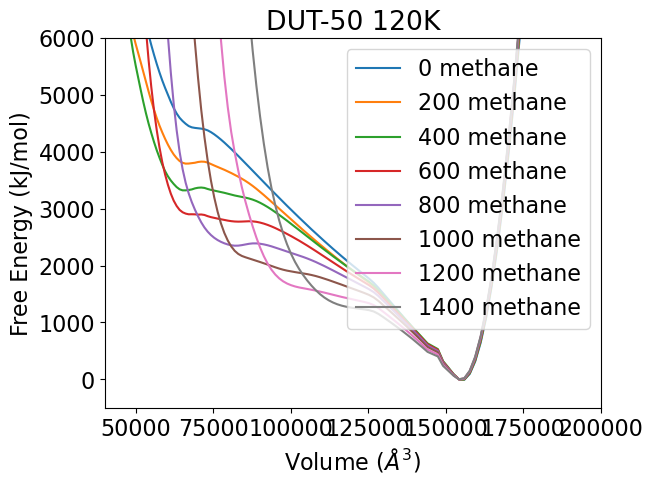

0 methane: 140    154249.37
Name: volume, dtype: float64, [0.]
200 methane: 69      69072.401
131    154249.370
Name: volume, dtype: float64, [3910.8392659    0.       ]
Energy Well Difference: 3910.83926590372
maxima_indices: (array([2], dtype=int64),)
g* left to right: -8.24924421243486
g* right to left: -3919.088510116155
400 methane: 58      69072.401
120    154249.370
Name: volume, dtype: float64, [3550.97237761    0.        ]
Energy Well Difference: 3550.972377612721
maxima_indices: (array([1], dtype=int64),)
g* left to right: -5.524298655625898
g* right to left: -3556.496676268347
600 methane: 116    154249.37
Name: volume, dtype: float64, [0.]
800 methane: 108    154249.37
Name: volume, dtype: float64, [0.]
1000 methane: 100    154249.37
Name: volume, dtype: float64, [0.]
1200 methane: 97    154249.37
Name: volume, dtype: float64, [0.]
1400 methane: 88    154249.37
Name: volume, dtype: float64, [0.]


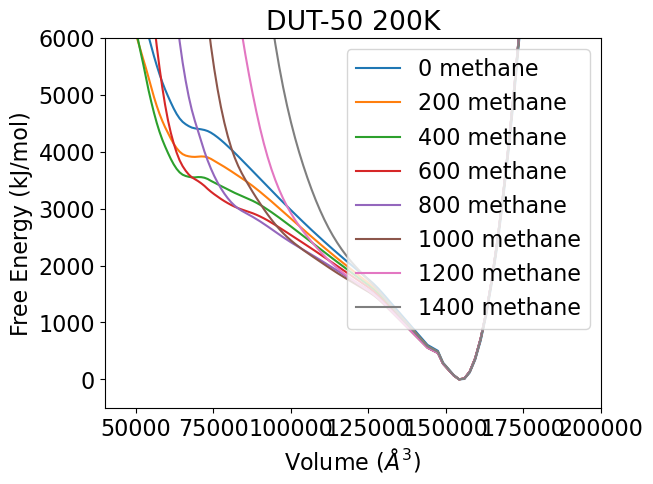


0 methane: 78      69072.401
140    154249.370
Name: volume, dtype: float64, [4341.56812554    0.        ]
Energy Well Difference: 4341.568125537626
maxima_indices: (array([2], dtype=int64),)
g* left to right: -1.182073695526924
g* right to left: -4342.750199233153
200 methane: 65      69072.401
127    154249.370
Name: volume, dtype: float64, [4098.73058582    0.        ]
Energy Well Difference: 4098.730585824058
maxima_indices: (array([2], dtype=int64),)
g* left to right: -3.4951356259698514
g* right to left: -4102.225721450028
400 methane: 118    154249.37
Name: volume, dtype: float64, [0.]
600 methane: 112    154249.37
Name: volume, dtype: float64, [0.]
800 methane: 106    154249.37
Name: volume, dtype: float64, [0.]
1000 methane: 98    154249.37
Name: volume, dtype: float64, [0.]
1200 methane: 94    154249.37
Name: volume, dtype: float64, [0.]
1400 methane: 89    155981.52
Name: volume, dtype: float64, [-17.15605133]


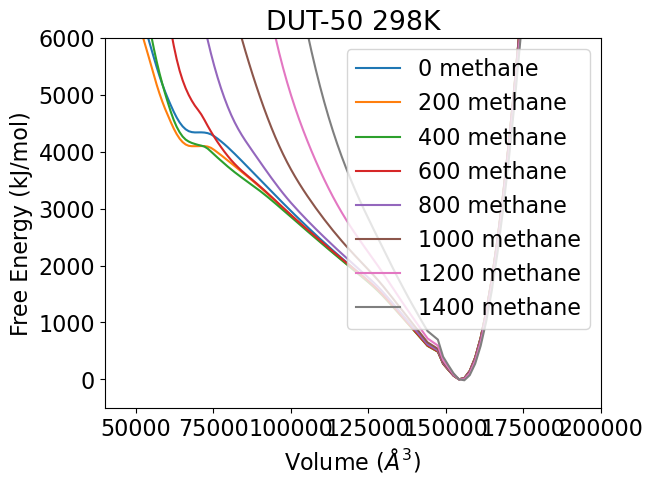

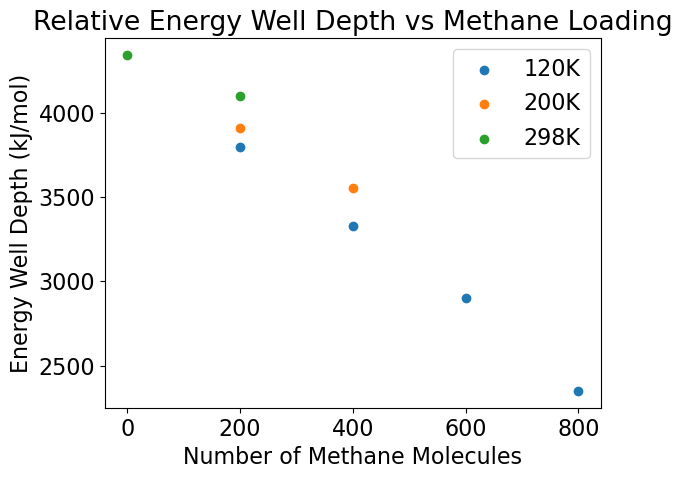

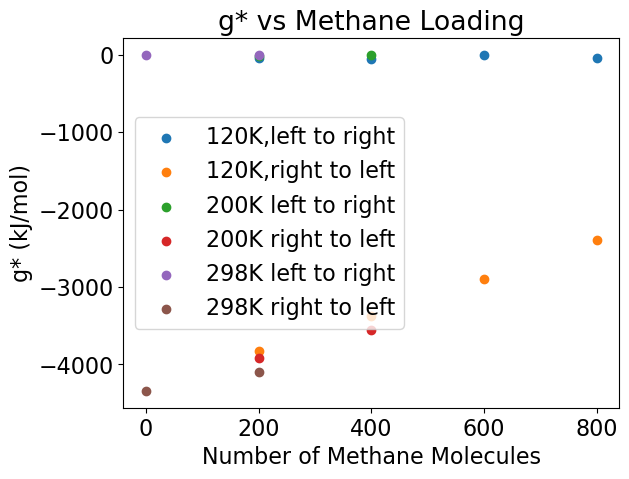

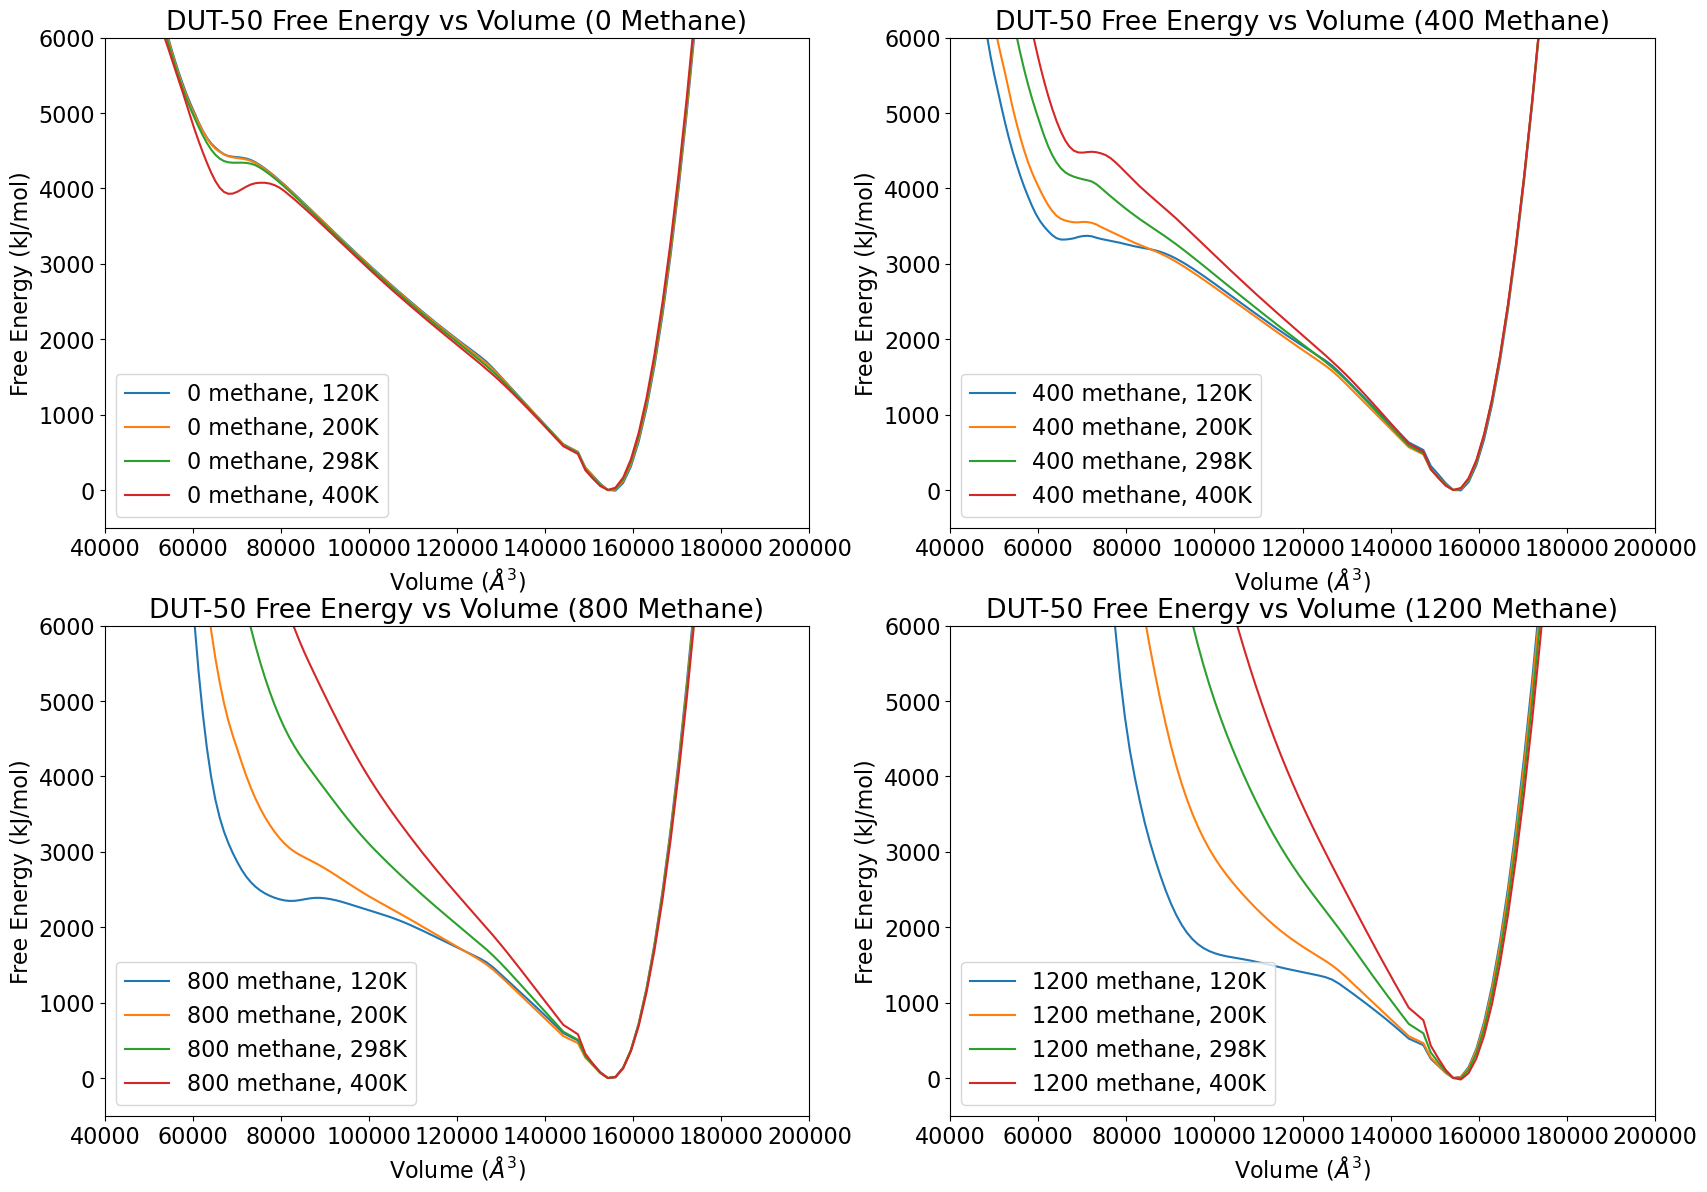

In [41]:
# Read in free energies and volumes from each file in FreeEnergy_Sept_data using get_FE_profile

DUT50_120K_data_dict = {}
DUT50_200K_data_dict = {}
DUT50_298K_data_dict = {}
DUT50_400K_data_dict = {}
DUT50_120K_depth_dict = {}
DUT50_200K_depth_dict = {}
DUT50_298K_depth_dict = {}
del_g_star_ltor_methane = {120:[], 200:[], 298:[]}
del_g_star_rtol_dict = {120:[], 200:[], 298:[]}
del_g_star_rtol_methane = {120:[], 200:[], 298:[]}
del_g_star_ltor_dict = {120:[], 200:[], 298:[]}


# 1. Read in the data
for file in os.listdir('FreeEnergy_Sept_data'):
    if file.endswith('.txt'):
        #print(file)
        df, free_eng = get_FE_profile('FreeEnergy_Sept_data/' + file, 155000)
        if 'DUT-50' in file and '120K' in file:
            num_methane = int(file.split('_')[3].split('m')[0])
            DUT50_120K_data_dict[num_methane] = (df, free_eng)
        elif 'DUT-50' in file and '200K' in file:
            num_methane = int(file.split('_')[3].split('m')[0])
            DUT50_200K_data_dict[num_methane] = (df, free_eng)
        elif 'DUT-50' in file and '298K' in file:
            num_methane = int(file.split('_')[3].split('m')[0])
            DUT50_298K_data_dict[num_methane] = (df, free_eng)
            print(file)
        elif 'DUT-50' in file and '400K' in file:
            num_methane = int(file.split('_')[3].split('m')[0])
            DUT50_400K_data_dict[num_methane] = (df, free_eng)
            print(file)

# Sort the data by number of methane molecules
DUT50_120K_data_dict = dict(sorted(DUT50_120K_data_dict.items()))
DUT50_200K_data_dict = dict(sorted(DUT50_200K_data_dict.items()))
DUT50_298K_data_dict = dict(sorted(DUT50_298K_data_dict.items()))
DUT50_400K_data_dict = dict(sorted(DUT50_400K_data_dict.items()))

# 2. Plot the data
fig, ax = plt.subplots()
for num_methane, (df, free_eng) in DUT50_120K_data_dict.items():
    ax.plot(df['volume'], free_eng, label=f'{num_methane} methane')
    masked_FE = free_eng[free_eng < 6000]
    minima_indices = argrelmin(masked_FE)
    # print the volume and free energy of the minima
    print(f'{num_methane} methane: {df["volume"][free_eng < 6000].iloc[minima_indices]}, {masked_FE[minima_indices]}')
    if len(minima_indices[0]) > 1:
        print(f'Energy Well Difference: {masked_FE[minima_indices[0][0]] - masked_FE[minima_indices[0][-1]]}')
        DUT50_120K_depth_dict[num_methane] = masked_FE[minima_indices[0][0]] - masked_FE[minima_indices[0][-1]]
        # find maximum between the two minima
        maxima_indices = argrelmax(masked_FE[minima_indices[0][0]:minima_indices[0][-1]])
        print(f'maxima_indices: {maxima_indices}')
        g_star_ltor = masked_FE[minima_indices[0][0]] - masked_FE[minima_indices[0][0]:minima_indices[0][-1]][maxima_indices[0][0]]
        g_star_rtol = masked_FE[minima_indices[0][-1]] - masked_FE[minima_indices[0][0]:minima_indices[0][-1]][maxima_indices[0][0]]
        print(f'g* left to right: {g_star_ltor}')
        print(f'g* right to left: {g_star_rtol}')
        # save the g* values
        del_g_star_ltor_dict[120].append(g_star_ltor)
        del_g_star_rtol_dict[120].append(g_star_rtol)
        del_g_star_ltor_methane[120].append(num_methane)
        del_g_star_rtol_methane[120].append(num_methane)

ax.legend()
ax.set_xlabel('Volume ($\AA^3$)')
ax.set_ylabel('Free Energy (kJ/mol)')
ax.set_ylim(-500, 6000)
ax.set_xlim(40000, 200000)
plt.title('DUT-50 120K')
plt.savefig('DUT50_120K.png', dpi=400)
plt.show()

fig, ax = plt.subplots()
for num_methane, (df, free_eng) in DUT50_200K_data_dict.items():
    ax.plot(df['volume'], free_eng, label=f'{num_methane} methane')#, linestyle='--')
    masked_FE = free_eng[free_eng < 6000]
    minima_indices = argrelmin(masked_FE)
    # print the volume and free energy of the minima
    print(f'{num_methane} methane: {df["volume"][free_eng < 6000].iloc[minima_indices]}, {masked_FE[minima_indices]}')
    if len(minima_indices[0]) > 1:
        print(f'Energy Well Difference: {masked_FE[minima_indices[0][0]] - masked_FE[minima_indices[0][1]]}')
        DUT50_200K_depth_dict[num_methane] = masked_FE[minima_indices[0][0]] - masked_FE[minima_indices[0][1]]
        # find maximum between the two minima
        maxima_indices = argrelmax(masked_FE[minima_indices[0][0]:minima_indices[0][1]])
        print(f'maxima_indices: {maxima_indices}')
        g_star_ltor = masked_FE[minima_indices[0][0]] - masked_FE[minima_indices[0][0]:minima_indices[0][1]][maxima_indices[0][0]]
        g_star_rtol = masked_FE[minima_indices[0][1]] - masked_FE[minima_indices[0][0]:minima_indices[0][1]][maxima_indices[0][0]]
        print(f'g* left to right: {g_star_ltor}')
        print(f'g* right to left: {g_star_rtol}')
        # save the g* values
        del_g_star_ltor_dict[200].append(g_star_ltor)
        del_g_star_rtol_dict[200].append(g_star_rtol)
        del_g_star_ltor_methane[200].append(num_methane)
        del_g_star_rtol_methane[200].append(num_methane)

ax.legend()
ax.set_xlabel('Volume ($\AA^3$)')
ax.set_ylabel('Free Energy (kJ/mol)')
ax.set_ylim(-500, 6000)
ax.set_xlim(40000, 200000)
plt.title('DUT-50 200K')
plt.savefig('DUT50_200K.png', dpi=400)
plt.show()

print()
fig, ax = plt.subplots()
for num_methane, (df, free_eng) in DUT50_298K_data_dict.items():
    ax.plot(df['volume'], free_eng, label=f'{num_methane} methane')#, linestyle=':')
    masked_FE = free_eng[free_eng < 6000]
    minima_indices = argrelmin(masked_FE)
    # print the volume and free energy of the minima
    print(f'{num_methane} methane: {df["volume"][free_eng < 6000].iloc[minima_indices]}, {masked_FE[minima_indices]}')
    if len(minima_indices[0]) > 1:
        print(f'Energy Well Difference: {masked_FE[minima_indices[0][0]] - masked_FE[minima_indices[0][1]]}')
        DUT50_298K_depth_dict[num_methane] = masked_FE[minima_indices[0][0]] - masked_FE[minima_indices[0][1]]
        # find maximum between the two minima
        maxima_indices = argrelmax(masked_FE[minima_indices[0][0]:minima_indices[0][1]])
        print(f'maxima_indices: {maxima_indices}')
        g_star_ltor = masked_FE[minima_indices[0][0]] - masked_FE[minima_indices[0][0]:minima_indices[0][1]][maxima_indices[0][0]]
        g_star_rtol = masked_FE[minima_indices[0][1]] - masked_FE[minima_indices[0][0]:minima_indices[0][1]][maxima_indices[0][0]]
        print(f'g* left to right: {g_star_ltor}')
        print(f'g* right to left: {g_star_rtol}')
        # save the g* values
        del_g_star_ltor_dict[298].append(g_star_ltor)
        del_g_star_rtol_dict[298].append(g_star_rtol)
        del_g_star_ltor_methane[298].append(num_methane)
        del_g_star_rtol_methane[298].append(num_methane)

ax.legend()
ax.set_xlabel('Volume ($\AA^3$)')
ax.set_ylabel('Free Energy (kJ/mol)')
ax.set_ylim(-500, 6000)
ax.set_xlim(40000, 200000)
plt.title('DUT-50 298K')
plt.savefig('DUT50_298K.png', dpi=400)
plt.show()


"""
# Plot the energy well differences for bipyridine grouped by temperature in a bar graph
fig, ax = plt.subplots()
depths = [DUT50_120K_depth_dict, DUT50_200K_depth_dict, DUT50_298K_depth_dict]
temps = [120, 200, 298]
x = np.arange(len(DUT50_120K_depth_dict.keys()))
width = 0.25
multiplier = 0

for depth_dict in depths:
    depth = depth_dict.values()
    methane_nums = depth_dict.keys()
    methane_num = list(methane_nums)[multiplier]
    offset = width * multiplier
    rects = ax.bar(x + offset, depth, width, label=f'{methane_num} methane molecules')
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.legend()
ax.set_xticks(x+width, list(methane_nums))
ax.set_ylabel('Energy Well Depth (kJ/mol)')
ax.set_xlabel('Temperature (K)')
ax.set_ylim(-500, 1500)
plt.show()
"""

# scatter plot of methane loadings vs depth of energy well
fig, ax = plt.subplots()
ax.scatter(DUT50_120K_depth_dict.keys(), DUT50_120K_depth_dict.values(), label='120K')
ax.scatter(DUT50_200K_depth_dict.keys(), DUT50_200K_depth_dict.values(), label='200K')
ax.scatter(DUT50_298K_depth_dict.keys(), DUT50_298K_depth_dict.values(), label='298K')
ax.set_xlabel('Number of Methane Molecules')
ax.set_ylabel('Energy Well Depth (kJ/mol)')
ax.set_title(f'Relative Energy Well Depth vs Methane Loading')
ax.legend()
plt.savefig('DUT-50_Energy_Well_Depth_vs_Methane_Loading.png', dpi=400)
plt.show()

# scatter plot of methane loadings vs g* values
fig, ax = plt.subplots()
ax.scatter(del_g_star_ltor_methane[120], del_g_star_ltor_dict[120], label='120K,left to right')
ax.scatter(del_g_star_rtol_methane[120], del_g_star_rtol_dict[120], label='120K,right to left')
ax.scatter(del_g_star_ltor_methane[200], del_g_star_ltor_dict[200], label='200K left to right')
ax.scatter(del_g_star_rtol_methane[200], del_g_star_rtol_dict[200], label='200K right to left')
ax.scatter(del_g_star_ltor_methane[298], del_g_star_ltor_dict[298], label='298K left to right')
ax.scatter(del_g_star_rtol_methane[298], del_g_star_rtol_dict[298], label='298K right to left')
ax.set_xlabel('Number of Methane Molecules')
ax.set_ylabel('g* (kJ/mol)')
ax.set_title(f'g* vs Methane Loading')
ax.legend()
plt.show()

# Plot by loading with temperature in legend, volume on x-axis, and free energy on y-axis
fig, ax = plt.subplots(2, 2, figsize=(20, 14))
for T in [120, 200, 298, 400]:
    for num_methane, (df, free_eng) in eval(f'DUT50_{T}K_data_dict').items():
        if num_methane == 0:
            ax[0,0].plot(df['volume'], free_eng, label=f'{num_methane} methane, {T}K')
        if num_methane == 400:
            ax[0,1].plot(df['volume'], free_eng, label=f'{num_methane} methane, {T}K')
        if num_methane == 800:
            ax[1,0].plot(df['volume'], free_eng, label=f'{num_methane} methane, {T}K')
        if num_methane == 1200:
            ax[1,1].plot(df['volume'], free_eng, label=f'{num_methane} methane, {T}K')

ax[0,0].legend(); ax[0,1].legend(); ax[1,0].legend(); ax[1,1].legend()
ax[0,0].set_xlabel('Volume ($\AA^3$)'); ax[0,1].set_xlabel('Volume ($\AA^3$)'); ax[1,0].set_xlabel('Volume ($\AA^3$)'); ax[1,1].set_xlabel('Volume ($\AA^3$)')
ax[0,0].set_ylabel('Free Energy (kJ/mol)'); ax[0,1].set_ylabel('Free Energy (kJ/mol)'); ax[1,0].set_ylabel('Free Energy (kJ/mol)'); ax[1,1].set_ylabel('Free Energy (kJ/mol)')
ax[0,0].set_ylim(-500, 6000); ax[0,1].set_ylim(-500, 6000); ax[1,0].set_ylim(-500, 6000); ax[1,1].set_ylim(-500, 6000)
ax[0,0].set_xlim(40000, 200000); ax[0,1].set_xlim(40000, 200000); ax[1,0].set_xlim(40000, 200000); ax[1,1].set_xlim(40000, 200000)

ax[0,0].set_title('DUT-50 Free Energy vs Volume (0 Methane)')
ax[0,1].set_title('DUT-50 Free Energy vs Volume (400 Methane)')
ax[1,0].set_title('DUT-50 Free Energy vs Volume (800 Methane)')
ax[1,1].set_title('DUT-50 Free Energy vs Volume (1200 Methane)')

plt.savefig('DUT-50_Free_Energy_vs_Volume_by_Loading_and_Temperature.png', dpi=400)
plt.show()